# Ideas
1. Analyze frequency space of delta-v
    + Negative delta-Vs could represent events of resistance to flow (attachment)
    + I still want to explore this! delta-v is very noisy though
2. Compare velocities at matched time points
    + Flow conditions could be inconsistent, we would want to observe
    + Interesting will try
3. Annotation review (check for errors and anomalies)
4. ~~Time vs Point ID~~
    + ~~Time is global but how can we use this with the PID variable to represent time local to the track
    + **This isn't a good proxy, better to use offset distance or normalized distance**
    + **Add in time interpolation**
5. Can we find characterizable differences between attached/unattached cells?
    + Back burnered

# MTrackJ Data Columns

1. **Nr** Unique ID
2. **TID** Track ID
3. **PID** Point ID
4. **x**
5. **y**
6. **t** Time
7. ~~**l** Pixel intensity (Not sure if we can use this)~~
8. **Len** ? similar to d2s
9. **D2S** "distance 2 start" (shortest distance: displacement)
10. ~~**D2r** Same as **D2S** but for a specified reference point (Currently not using this feature)~~
11. **D2P** "distance 2 point" (distance from last point)
12. **v** Velocity calculated by last displacement vector divided by time interval 
13. **α** Angle displacement relative to previous point. (0 deg = East, +90 = South, etc.)
14. **Δα** Change in angle displacement

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
%matplotlib inline

# Load in Data

## Todo:
1.  Multiple csv loading for multi lane experiments with names/conditions

In [167]:
csv7 = "ln7bind_points.csv"
csv8 = "ln8bind_points.csv"

data_dir = "inputs/measurements"
project_dir = "~/code/lab/tc_tools"

ln7 = pd.read_csv(f"{project_dir}/{data_dir}/{csv7}")
ln8 = pd.read_csv(f"{project_dir}/{data_dir}/{csv8}")

ln7.set_index("Nr")
ln8.set_index("Nr")

,TID,PID,x [pixel],y [pixel],t [sec],I [val],Len [pixel],D2S [pixel],D2R [pixel],D2P [pixel],v [pixel/sec],α [deg],Δα [deg]
Nr,,,,,,,,,,,,,
1,1,1,191.833,15.500,141,22343,0.000,0.000,NaN,NaN,NaN,NaN,NaN
2,1,2,191.833,52.167,142,24627,36.667,36.667,NaN,36.667,36.667,90.000,NaN
3,1,3,189.833,80.167,143,16475,64.738,64.698,NaN,28.071,28.071,94.086,4.086
4,1,4,191.833,103.500,144,16945,88.157,88.000,NaN,23.419,23.419,85.101,-8.985
5,1,5,191.167,130.167,145,22879,114.832,114.669,NaN,26.675,26.675,91.432,6.331
...,...,...,...,...,...,...,...,...,...,...,...,...,...
436,25,12,208.833,118.833,404,27577,116.722,113.664,NaN,11.508,0.500,100.008,25.532
437,25,13,207.500,126.833,419,15091,124.832,121.555,NaN,8.110,0.541,99.462,-0.546
438,25,14,207.500,131.500,457,15828,129.499,126.213,NaN,4.667,0.123,90.000,-9.462


# Subset and Rename columns of interest

## TODO: 
1. Create function to process multiple datasets

In [168]:
columns_of_interest = ["TID", 
                       "PID",
                       "x [pixel]", 
                       "y [pixel]",
                       "t [sec]", 
                       "v [pixel/sec]", 
                       "D2S [pixel]"]

new_cols = ["x","y","t","v","dist"]
ln7 = ln7[columns_of_interest]
ln8 = ln8[columns_of_interest]

# Rename columns
replace_cols = dict(zip(columns_of_interest[2:],new_cols))
ln7 = ln7.rename(columns=replace_cols)
ln8 = ln8.rename(columns=replace_cols)
ln7.head(6)

,TID,PID,x,y,t,v,dist
0,1,1,164.167,22.833,882,NaN,0.000
1,1,2,162.167,59.500,883,36.721,36.721
2,1,3,160.167,95.500,884,36.056,72.777
3,1,4,160.833,128.833,885,33.340,106.052
4,1,5,160.833,163.500,886,34.667,140.706
5,1,6,159.500,196.833,887,33.360,174.063


# Interpolate Sparse Measurements across time
Currently fast movements are annotated frame by frame but slow movements skip around to next "exciting" event. This causes jumps and time to be a not useful x axis. We can correct this by interpolating. Do we interpolate back and forward though? No track begins at time = 0, but all tracks end at time = final_time. We can leave global time alone then and not have to create local time and interpolate inside the first track time to the last global time point.

We will need to create empty points in between time gaps and then fill via interpolation.

## Thoughts
Currently it doesn't seem like this interpolation is doing much for us. Could be:
1. Wrong type of interpolation
2. Interpolation is not useful in these analyses


# Interpolating Time Values

1. Move time to index
2. Replace with index spanning to end
    + This creates NaNs in between sparse times correctly
3. Fill NaNs:
    + **TID** fill with current value
    + **PID** just make a new series
    + **x,y,v,dist** just interpolate?
        + This isn't working properly, giving identical results as before.
    + **dv** should be created from whatever v is created
4. Reset Index
5. Create New Global Index

In [349]:
ln7[ln7["TID"]==5]

,TID,PID,x,y,t,v,dist,dv,d_off,t_corr
51,5,1,94.167,22.833,412,24.667,0.000,0.000,-316.684,0
52,5,2,94.167,47.500,413,24.667,24.667,0.000,-292.017,1
53,5,3,90.833,74.833,414,27.536,52.107,2.869,-264.577,2
54,5,4,93.500,94.833,415,20.177,72.003,-7.359,-244.681,3
55,5,5,94.167,100.167,416,5.375,77.333,-14.802,-239.351,4
56,5,6,94.167,108.833,417,8.667,86.000,3.292,-230.684,5
57,5,7,94.833,128.167,418,19.345,105.335,10.678,-211.349,6
58,5,8,93.500,150.167,419,22.040,127.335,2.695,-189.349,7
59,5,9,90.833,170.167,420,20.177,147.371,-1.863,-169.313,8
60,5,10,91.500,191.500,421,21.344,168.688,1.167,-147.996,9


In [348]:
tester = create_missing_timepoints(ln7[ln7["TID"]==5])
tester.head(30)

,t,TID,PID,x,y,v,dist,dv,d_off,t_corr
0,412,5,1,94.167000,22.833000,24.667000,0.000000,0.000,-316.684,0.0
1,413,5,2,94.167000,47.500000,24.667000,24.667000,0.000,-292.017,1.0
2,414,5,3,90.833000,74.833000,27.536000,52.107000,2.869,-264.577,2.0
3,415,5,4,93.500000,94.833000,20.177000,72.003000,-7.359,-244.681,3.0
4,416,5,5,94.167000,100.167000,5.375000,77.333000,-14.802,-239.351,4.0
5,417,5,6,94.167000,108.833000,8.667000,86.000000,3.292,-230.684,5.0
6,418,5,7,94.833000,128.167000,19.345000,105.335000,10.678,-211.349,6.0
7,419,5,8,93.500000,150.167000,22.040000,127.335000,2.695,-189.349,7.0
8,420,5,9,90.833000,170.167000,20.177000,147.371000,-1.863,-169.313,8.0
9,421,5,10,91.500000,191.500000,21.344000,168.688000,1.167,-147.996,9.0


In [343]:
def create_missing_timepoints(track):
    new_range = (track["t"].min(), track["t"].max()+1)
    new_time_index = pd.Index(np.arange(*new_range,1), name="t")
    copy = track.set_index("t").reindex(new_time_index)
    
    # Interpolate columns appropriately
    copy["TID"].interpolate(method="pad",inplace=True)
    copy = copy.astype({"TID":int})
    copy["PID"] = new_pid = np.arange(1,len(copy)+1,1)
    
    copy["x"].interpolate(inplace=True)
    copy["y"].interpolate(inplace=True)
    copy["v"].interpolate(inplace=True)
    copy["dist"].interpolate(inplace=True)
    
    res = copy.reset_index()
    return res

In [271]:
inter7 = ln7.groupby("TID").apply(func=create_missing_timepoints)
new_index = pd.Index(np.arange(1,len(inter7)+1,1),name="Nr")
inter7 = inter7.set_index(new_index)

inter8 = ln8.groupby("TID").apply(func=create_missing_timepoints)
new_index = pd.Index(np.arange(1,len(inter8)+1,1),name="Nr")
inter8 = inter8.set_index(new_index)

In [322]:
first_points = ln7["PID"] <= 2
fpoints = inter7["PID"] <= 2

In [471]:
ln7[ln7["TID"]==8].head(30)

,TID,PID,x,y,t,v,dist,dv,d_off,t_corr
96,8,1,216.833,0.833,492,28.008,0.000,0.000,-220.049,0
97,8,2,216.167,28.833,493,28.008,28.008,0.000,-192.041,1
98,8,3,218.167,54.833,494,26.077,54.016,-1.931,-166.033,2
99,8,4,217.500,83.500,495,28.674,82.669,2.597,-137.380,3
100,8,5,216.167,108.167,496,24.703,107.335,-3.971,-112.714,4
101,8,6,214.833,136.167,497,28.032,135.348,3.329,-84.701,5
102,8,7,212.833,165.500,498,29.401,164.715,1.369,-55.334,6
103,8,8,214.833,192.167,499,26.742,191.344,-2.659,-28.705,7
104,8,9,212.833,199.500,500,7.601,198.707,-19.141,-21.342,8
105,8,10,212.167,200.833,501,1.491,200.054,-6.110,-19.995,9


In [472]:
inter7.to_csv("cd44_inter.csv")
inter8.to_csv("wt_inter.csv")

In [470]:
inter7[inter7["TID"]==8].head(30)

,t,TID,PID,x,y,v,dist,dv,d_off,t_corr
Nr,,,,,,,,,,
10804,492,8,1,216.833,0.833,28.008,0.000,0.000,-220.049,0
10805,493,8,2,216.167,28.833,28.008,28.008,0.000,-192.041,1
10806,494,8,3,218.167,54.833,26.077,54.016,-1.931,-166.033,2
10807,495,8,4,217.500,83.500,28.674,82.669,2.597,-137.380,3
10808,496,8,5,216.167,108.167,24.703,107.335,-3.971,-112.714,4
10809,497,8,6,214.833,136.167,28.032,135.348,3.329,-84.701,5
10810,498,8,7,212.833,165.500,29.401,164.715,1.369,-55.334,6
10811,499,8,8,214.833,192.167,26.742,191.344,-2.659,-28.705,7
10812,500,8,9,212.833,199.500,7.601,198.707,-19.141,-21.342,8


In [324]:
ln7[first_points].head(6)

,TID,PID,x,y,t,v,dist,dv,d_off,t_corr
0,1,1,164.167,22.833,882,36.721,0.000,0.0,-248.795,0
1,1,2,162.167,59.500,883,36.721,36.721,0.0,-212.074,1
11,2,1,352.167,26.833,634,35.358,0.000,0.0,-236.727,0
12,2,2,353.500,62.167,635,35.358,35.358,0.0,-201.369,1
25,3,1,451.500,17.500,618,30.000,0.000,0.0,-147.333,0
26,3,2,451.500,47.500,619,30.000,30.000,0.0,-117.333,1


# Handling NaN for initial values
1. Velocity 
    1. ~~NaN --> 0~~
        + This assumes that the cell was standing still previously, not a good assumption
    2. Drop NaN?
        + Removes data, isn't working too well
    3. NaN --> next value
        + **It feels like a safe assumption to assume that before we tracked the cell in the field, it was going a similar speed**
2. Acceleration
    1. NaN --> next value
        + Given velocity NaN conversion this means we have NaN and then 0, safe to convert all NaNs to zero assuming negligible change in velocity on first two initial points

In [274]:
ln7 = ln7.fillna(method="bfill")
ln8 = ln8.fillna(method="bfill")

inter7 = inter7.fillna(method="bfill")
inter8 = inter8.fillna(method="bfill")


#ln7[first_points].head(6)
inter7[fpoints].head(6)

,t,TID,PID,x,y,v,dist
Nr,,,,,,,
1,882,1,1,164.167,22.833,36.721,0.000
2,883,1,2,162.167,59.500,36.721,36.721
1226,634,2,1,352.167,26.833,35.358,0.000
1227,635,2,2,353.500,62.167,35.358,35.358
2699,618,3,1,451.500,17.500,30.000,0.000
2700,619,3,2,451.500,47.500,30.000,30.000


# Adding delta v column

## TODO:
1. This creates a new NaN value in delta v. How should we deal with this?
    + **backfill**
2. **ISSUE**: the code only generates NaN for first value because is not doing diff in TRACK context like mtrack
    + do diff via groupby track

In [275]:
def get_dv(track):
    return pd.DataFrame(track["v"].diff())
ln7["dv"] = ln7.groupby("TID").apply(func=get_dv)
ln8["dv"] = ln8.groupby("TID").apply(func=get_dv)

inter7["dv"] = inter7.groupby("TID").apply(func=get_dv)
inter8["dv"] = inter8.groupby("TID").apply(func=get_dv)

ln7[first_points].head(6)
inter7[fpoints].head(6)

,t,TID,PID,x,y,v,dist,dv
Nr,,,,,,,,
1,882,1,1,164.167,22.833,36.721,0.000,NaN
2,883,1,2,162.167,59.500,36.721,36.721,0.0
1226,634,2,1,352.167,26.833,35.358,0.000,NaN
1227,635,2,2,353.500,62.167,35.358,35.358,0.0
2699,618,3,1,451.500,17.500,30.000,0.000,NaN
2700,619,3,2,451.500,47.500,30.000,30.000,0.0


In [298]:
ln7 = ln7.fillna(method="bfill")
ln8 = ln8.fillna(method="bfill")

# NOTE: i don't know where i should round but i'll just do it here for now
inter7 = inter7.fillna(method="bfill").round(3)
inter8 = inter8.fillna(method="bfill").round(3)

ln7[first_points].head(6)
inter7[fpoints].head(6)
inter7[inter7["TID"]==5]

,t,TID,PID,x,y,v,dist,dv
Nr,,,,,,,,
6031,412,5,1,94.167,22.833,24.667,0.000,0.000
6032,413,5,2,94.167,47.500,24.667,24.667,0.000
6033,414,5,3,90.833,74.833,27.536,52.107,2.869
6034,415,5,4,93.500,94.833,20.177,72.003,-7.359
6035,416,5,5,94.167,100.167,5.375,77.333,-14.802
...,...,...,...,...,...,...,...,...
7721,2102,5,1691,90.833,339.481,0.005,316.665,-0.000
7722,2103,5,1692,90.833,339.486,0.005,316.670,-0.000
7723,2104,5,1693,90.833,339.491,0.005,316.675,-0.000


# Delta V
1. Fixed the issue! velocity came baked in bc mtrack so it was "track context aware". However my dv calculation wasn't so it was performing diff on the whole set of points.

# Delta V Histogram
1. With the interpolation we have created a lottttt of new events so this is going to throw off the histogram.
2. Even by rounding to 3 decimal places it still doesn't fix the histogram

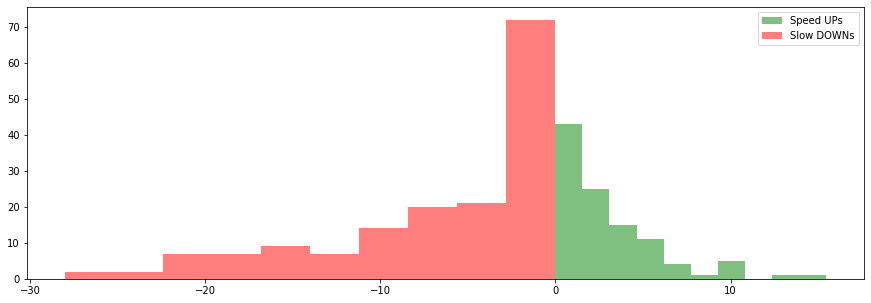

In [301]:
def dv_split(df):
    pos_dv = df["dv"]>0
    neg_dv = df["dv"]<0
    speedups = df.where(pos_dv).dropna()["dv"]
    slowdowns = df.where(neg_dv).dropna()["dv"]
    
    fig,ax = plt.subplots(figsize=(15,5))
    ax.hist(speedups,color="green", alpha=0.5, label="Speed UPs")
    ax.hist(slowdowns,color="red", alpha = 0.5, label="Slow DOWNs")
    ax.legend(loc="upper right")

    plt.show()

dv_split(ln7)

# Normalize Distance Traveled

## TODO:
1. We can try normalizing the amount of points each track has? By interpolating or removing other points. Not sure if this would be useful
2. This doesn't seem useful yet, going to backburner

In [302]:
def norm_dist(track):
    zero_vel = track["v"] < 1 # The velocity might not be exactly 0, need threshold
    stopping_points = track.where(zero_vel) # It is possible that the cell stops at multiple points
    stopping_points = stopping_points.dropna()
    final_dist = stopping_points["dist"].max() # Get the furthest point, based on distance
    return pd.DataFrame(track["dist"]/final_dist*100 )

In [152]:
norm = ln7.groupby("TID").apply(func=norm_dist)
ln7["d_norm"] = norm
norm = ln8.groupby("TID").apply(func=norm_dist)
ln8["d_norm"] = norm

# Zero Velocity Distance --> Endpoint Offset

In [303]:
def offset_stopping_distance(track):
    zero_vel = track["v"] < 0.75 # The velocity might not be exactly 0, need threshold
    stopping_points = track.where(zero_vel) # It is possible that the cell stops at multiple points
    stopping_points = stopping_points.dropna()
    final_dist = stopping_points["dist"].max() # Get the furthest point, based on distance
    return pd.DataFrame(track["dist"] - final_dist)

In [306]:
ln7["d_off"] = ln7.groupby("TID").apply(func=offset_stopping_distance)
ln8["d_off"] = ln8.groupby("TID").apply(func=offset_stopping_distance)

inter7["d_off"] = inter7.groupby("TID").apply(func=offset_stopping_distance)
inter8["d_off"] = inter8.groupby("TID").apply(func=offset_stopping_distance) 

# Global Time --> Local Time

+ This might not be necessary if we use interpolation

In [305]:
def get_corrected(g):
    initial_time = g["t"].iloc[0]
    return pd.DataFrame(g["t"]-initial_time)

In [307]:
ln7["t_corr"] = ln7.groupby("TID").apply(func=get_corrected)
ln8["t_corr"] = ln8.groupby("TID").apply(func=get_corrected)

inter7["t_corr"] = inter7.groupby("TID").apply(func=get_corrected)
inter8["t_corr"] = inter8.groupby("TID").apply(func=get_corrected)

# dV at a glance
---

## Notes:
+ Should notice ratio of +/- dVs
+ Any other patterns?

## CD44

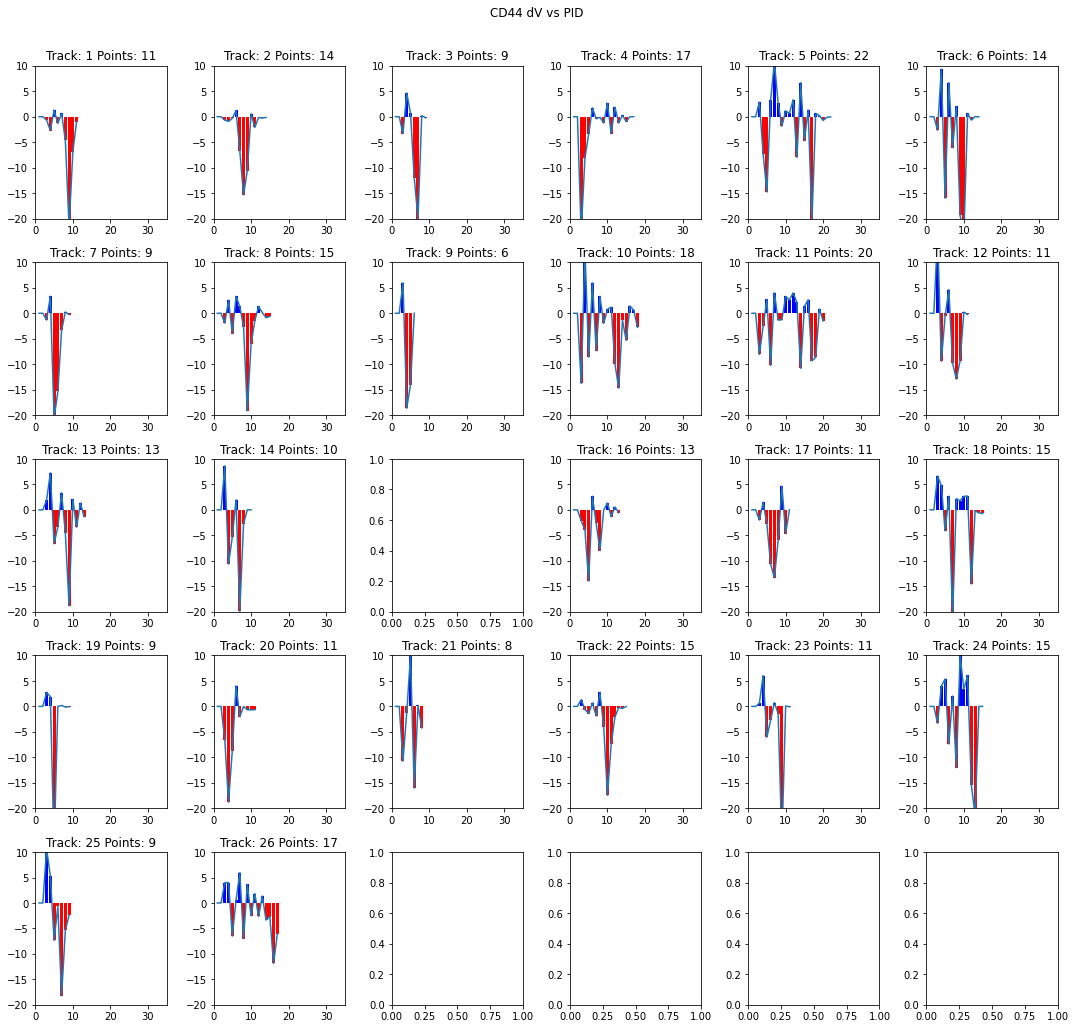

In [408]:
fig,ax = plt.subplots(5,6,figsize=(15,15))
ax = ax.ravel()
for i,track in ln7.groupby("TID"):
    points = track["PID"].max()
    ax[i-1].plot(track["PID"],track["dv"])
    ax[i-1].bar(track["PID"], track["dv"],
               color=(track["dv"]>=0).map({True: "Blue", False: "Red"}))
    ax[i-1].set_title(f"Track: {i} Points: {points}")
    ax[i-1].set_ylim([-20,10])
    ax[i-1].set_xlim([0,35])
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle("CD44 dV vs PID")
plt.show()

## WT

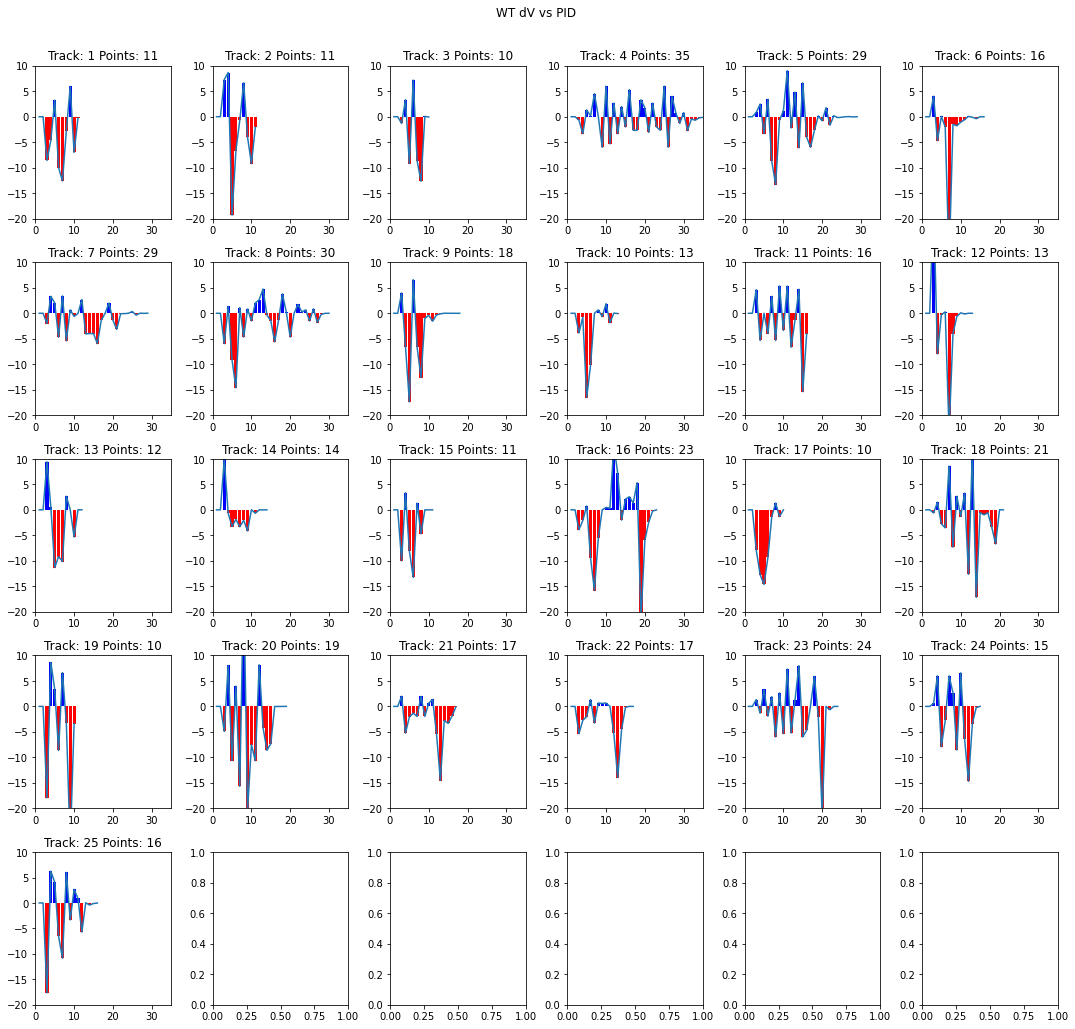

In [407]:
fig,ax = plt.subplots(5,6,figsize=(15,15))
ax = ax.ravel()
for i,track in ln8.groupby("TID"):
    points = track["PID"].max()
    ax[i-1].plot(track["PID"],track["dv"])
    ax[i-1].bar(track["PID"], track["dv"],
               color=(track["dv"]>=0).map({True: "Blue", False: "Red"}))
    ax[i-1].set_title(f"Track: {i} Points: {points}")
    ax[i-1].set_ylim([-20,10])
    ax[i-1].set_xlim([0,35])
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle("WT dV vs PID")
plt.show()

# Velocities at a glance
---

## Notes:
1. There seems to be little difference in using PID and Offset Distance, it just slightly changes graph shape in areas of sparse time annotation
2. Need to analyze with set window

## CD44

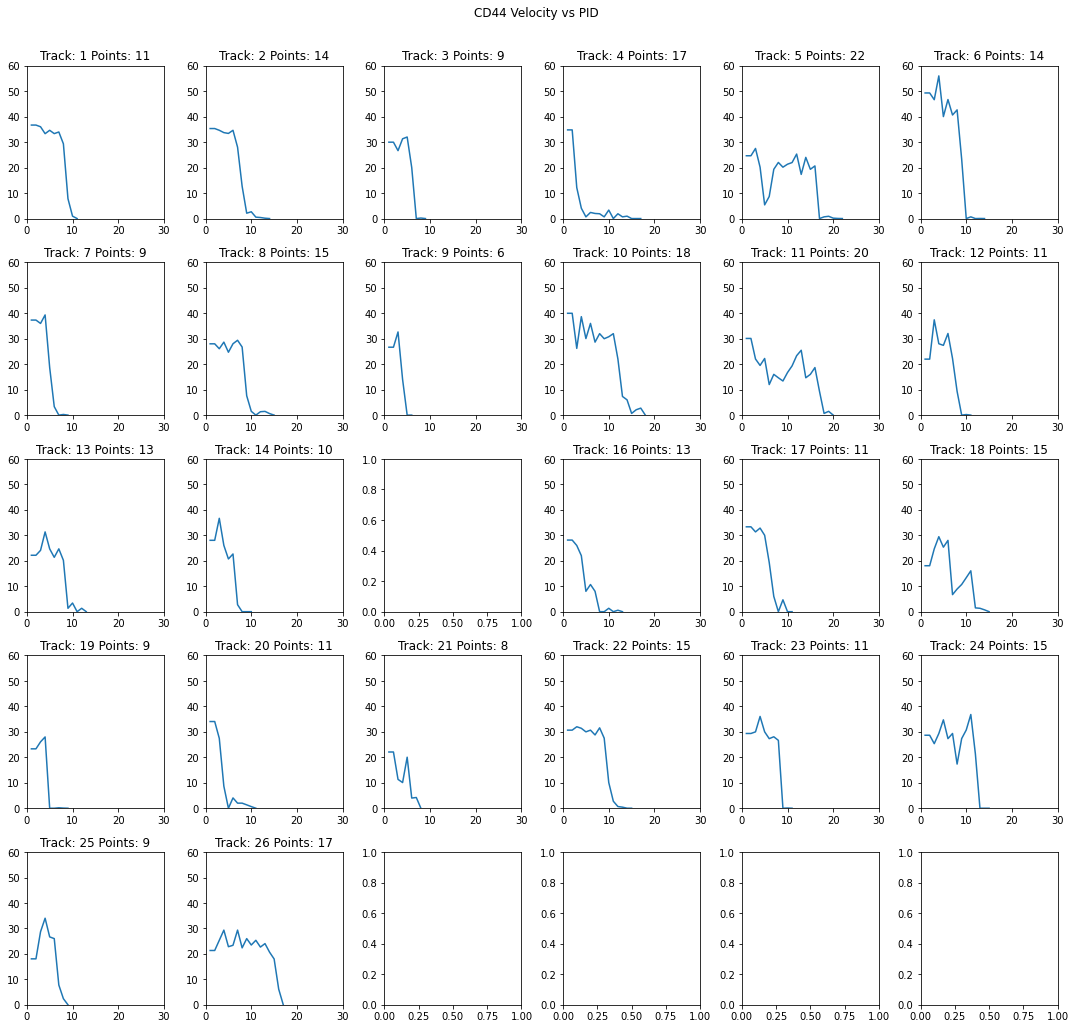

In [399]:
fig,ax = plt.subplots(5,6,figsize=(15,15))
ax = ax.ravel()
for i,track in ln7.groupby("TID"):
    points = track["PID"].max()
    ax[i-1].plot(track["PID"],track["v"])
    ax[i-1].set_title(f"Track: {i} Points: {points}")
    ax[i-1].set_ylim([0,60])
    ax[i-1].set_xlim([0,30])
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle("CD44 Velocity vs PID")
plt.show()

## WT

## Notes:
1. Track 4 seems to be an outlier and might be contributing to the huge difference between CD44 and WT.
    + Need to annotate more to be sure
    + Run technical replicates

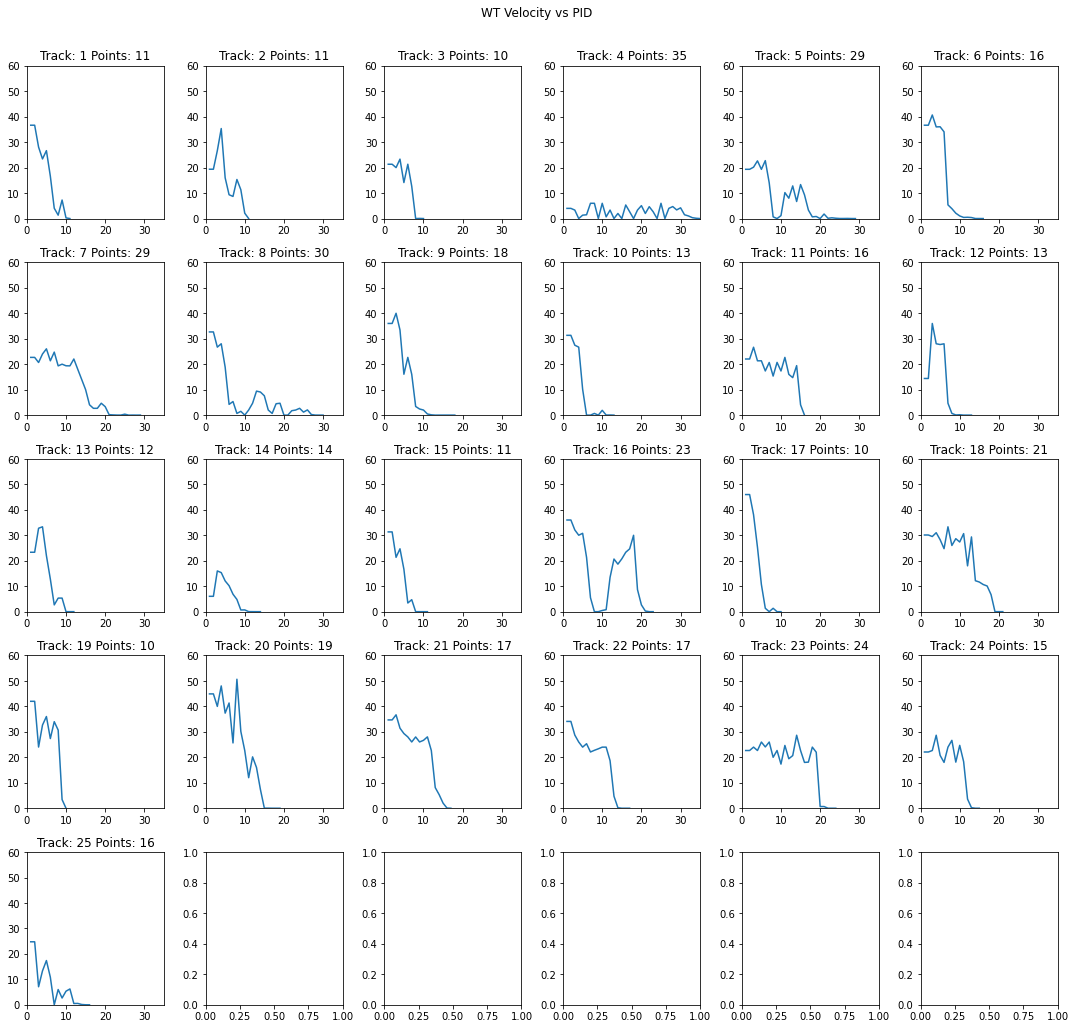

In [404]:
fig,ax = plt.subplots(5,6,figsize=(15,15))
ax = ax.ravel()
for i,track in ln8.groupby("TID"):
    points = track["PID"].max()
    ax[i-1].plot(track["PID"],track["v"])
    ax[i-1].set_title(f"Track: {i} Points: {points}")
    ax[i-1].set_ylim([0,60])
    ax[i-1].set_xlim([0,35])
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle("WT Velocity vs PID")
plt.show()

# Amount of stops per track

## Issues:
* Currently, this is NOT stops. This is slow movements. Which is still an interesting metric.
* What does a stop actually look like? It would be the initial falling edge, how do we capture this?
* Maybe we shouldn't even think of these as stops since none of these remain at zero until the very end
    + What should we call them then?

In [450]:
def old_stops(track):
    threshold = 0.5 # Need to find a way to leave this one argument function, factory?
    zero_vel = track["v"] < threshold # The velocity might not be exactly 0, need threshold
    stopping_points = track.where(zero_vel) # It is possible that the cell stops at multiple points
    stopping_points = stopping_points.dropna()
    return len(stopping_points)

# Falling Edge Detection
* We must cross a threshold in the negative direction to register a "stop". We cannot register another "stop" until we leave this threshold in the positive direction.
* Can we try detecting inflection points as well?
* What would this look like with dV instead?

In [448]:
def stops(track):
    threshold = 0.5 # Need to find a way to leave this one argument function, factory pattern?
    ones = track["v"] >= threshold
    zeroes = track["v"] < threshold
    
    # NOTE: need to read up on differences between chained indexing and loc for updating
    # Creating copy where velocities above threshold are 1 and below are 0 for simple transitions
    copy = pd.DataFrame(track)
    copy.loc[ones,"v"] = 1
    copy.loc[zeroes, "v"] = 0
    #print(copy["v"])
    
    current_state = 1 # Start HI
    slow_down_events = 0
    num_v = len(track["v"])
    for i in range(0,num_v):
        if i+1 < num_v:
            curr_v = track["v"].iloc[i]
            next_v = track["v"].iloc[i+1]
            window_sum = curr_v + next_v
            
            # FSM (there's probably a better way...)
            #print(f"{i}: {'HI' if current_state else 'LO'}")
            if current_state == 1: # Starting HI
                if window_sum == 1: # One LO is not enough
                    pass
                elif window_sum == 2: # Sustained HI signal
                    pass
                elif window_sum == 0: # Sustained LO signal: Transition (HI --> LO)
                    #print("HI -> LO")
                    #print(f"i: {i} i+1: {i+1}")
                    #print(f"Current: {curr_v} Next: {next_v} Window: {window_sum}")
                    slow_down_events += 1
                    current_state = 0
                else:
                    print("This shouldn't happen")
            elif current_state == 0: # Starting lo
                if window_sum == 1: # One HI is not enough
                    pass
                elif window_sum == 2: # Sustained HI signal: Transition (LO --> HI)
                    #print("LO -> HI")
                    #print(f"i: {i} i+1: {i+1}")
                    #print(f"Current: {curr_v} Next: {next_v} Window: {window_sum}")
                    current_state = 1
                elif window_sum == 0: # Sustained LO signal
                    pass
                else:
                    print("This shouldn't happen")
    return slow_down_events

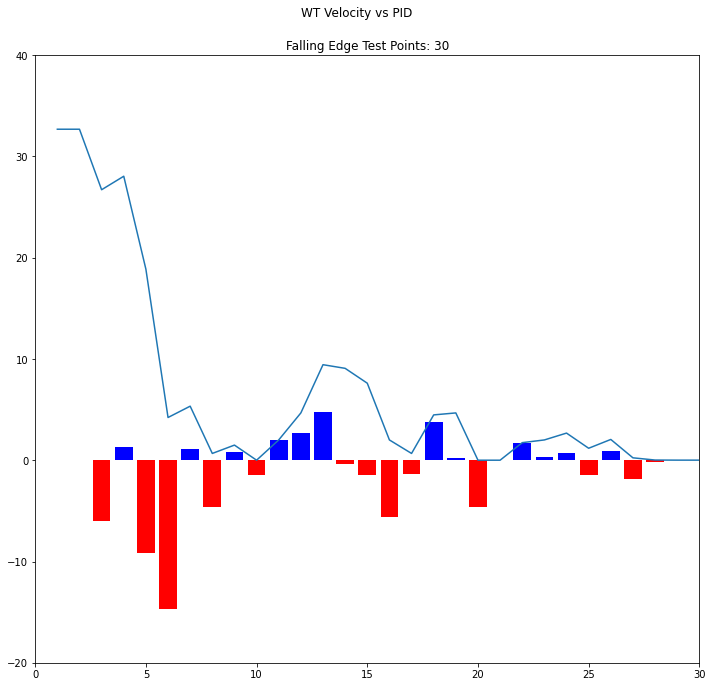

In [413]:
edge_test = ln8[ln8["TID"]==8]
fig,ax = plt.subplots(figsize=(10,10))

points = edge_test["PID"].max()
ax.plot(edge_test["PID"],edge_test["v"])
ax.bar(edge_test["PID"], edge_test["dv"],
           color=(edge_test["dv"]>=0).map({True: "Blue", False: "Red"}))
ax.set_title(f"Falling Edge Test Points: {points}")
ax.set_ylim([-20,40])
ax.set_xlim([0,30])

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle("WT Velocity vs PID")
plt.show()

In [453]:
cd44_stops = ln7.groupby("TID").apply(func=stops)
wt_stops = ln8.groupby("TID").apply(func=stops)

inter_cd44_stops = inter7.groupby("TID").apply(func=stops)
inter_wt_stops = inter8.groupby("TID").apply(func=stops)

0: HI
1: HI
2: HI
3: HI
4: HI
5: HI
6: HI
7: HI
8: HI
9: HI
0: HI
1: HI
2: HI
3: HI
4: HI
5: HI
6: HI
7: HI
8: HI
9: HI
10: HI
11: HI
HI -> LO
Current: 0.0 Next: 0.0 Window: 0.0
12: LO
0: HI
1: HI
2: HI
3: HI
4: HI
5: HI
6: HI
HI -> LO
Current: 0.0 Next: 0.0 Window: 0.0
7: LO
0: HI
1: HI
2: HI
3: HI
4: HI
5: HI
6: HI
7: HI
8: HI
9: HI
10: HI
11: HI
12: HI
13: HI
14: HI
HI -> LO
Current: 0.0 Next: 0.0 Window: 0.0
15: LO
0: HI
1: HI
2: HI
3: HI
4: HI
5: HI
6: HI
7: HI
8: HI
9: HI
10: HI
11: HI
12: HI
13: HI
14: HI
15: HI
16: HI
17: HI
18: HI
19: HI
HI -> LO
Current: 0.0 Next: 0.0 Window: 0.0
20: LO
0: HI
1: HI
2: HI
3: HI
4: HI
5: HI
6: HI
7: HI
8: HI
9: HI
10: HI
11: HI
HI -> LO
Current: 0.0 Next: 0.0 Window: 0.0
12: LO
0: HI
1: HI
2: HI
3: HI
4: HI
5: HI
6: HI
HI -> LO
Current: 0.0 Next: 0.0 Window: 0.0
7: LO
0: HI
1: HI
2: HI
3: HI
4: HI
5: HI
6: HI
7: HI
8: HI
9: HI
10: HI
11: HI
12: HI
13: HI
0: HI
1: HI
2: HI
3: HI
4: HI
HI -> LO
Current: 0.0 Next: 0.0 Window: 0.0
0: HI
1: HI
2: HI

999: LO
1000: LO
1001: LO
1002: LO
1003: LO
1004: LO
1005: LO
1006: LO
1007: LO
1008: LO
1009: LO
1010: LO
1011: LO
1012: LO
1013: LO
1014: LO
1015: LO
1016: LO
1017: LO
1018: LO
1019: LO
1020: LO
1021: LO
1022: LO
1023: LO
1024: LO
1025: LO
1026: LO
1027: LO
1028: LO
1029: LO
1030: LO
1031: LO
1032: LO
1033: LO
1034: LO
1035: LO
1036: LO
1037: LO
1038: LO
1039: LO
1040: LO
1041: LO
1042: LO
1043: LO
1044: LO
1045: LO
1046: LO
1047: LO
1048: LO
1049: LO
1050: LO
1051: LO
1052: LO
1053: LO
1054: LO
1055: LO
1056: LO
1057: LO
1058: LO
1059: LO
1060: LO
1061: LO
1062: LO
1063: LO
1064: LO
1065: LO
1066: LO
1067: LO
1068: LO
1069: LO
1070: LO
1071: LO
1072: LO
1073: LO
1074: LO
1075: LO
1076: LO
1077: LO
1078: LO
1079: LO
1080: LO
1081: LO
1082: LO
1083: LO
1084: LO
1085: LO
1086: LO
1087: LO
1088: LO
1089: LO
1090: LO
1091: LO
1092: LO
1093: LO
1094: LO
1095: LO
1096: LO
1097: LO
1098: LO
1099: LO
1100: LO
1101: LO
1102: LO
1103: LO
1104: LO
1105: LO
1106: LO
1107: LO
1108: LO
1109: LO
11

298: LO
299: LO
300: LO
301: LO
302: LO
303: LO
304: LO
305: LO
306: LO
307: LO
308: LO
309: LO
310: LO
311: LO
312: LO
313: LO
314: LO
315: LO
316: LO
317: LO
318: LO
319: LO
320: LO
321: LO
322: LO
323: LO
324: LO
325: LO
326: LO
327: LO
328: LO
329: LO
330: LO
331: LO
332: LO
333: LO
334: LO
335: LO
336: LO
337: LO
338: LO
339: LO
340: LO
341: LO
342: LO
343: LO
344: LO
345: LO
346: LO
347: LO
348: LO
349: LO
350: LO
351: LO
352: LO
353: LO
354: LO
355: LO
356: LO
357: LO
358: LO
359: LO
360: LO
361: LO
362: LO
363: LO
364: LO
365: LO
366: LO
367: LO
368: LO
369: LO
370: LO
371: LO
372: LO
373: LO
374: LO
375: LO
376: LO
377: LO
378: LO
379: LO
380: LO
381: LO
382: LO
383: LO
384: LO
385: LO
386: LO
387: LO
388: LO
389: LO
390: LO
391: LO
392: LO
393: LO
394: LO
395: LO
396: LO
397: LO
398: LO
399: LO
400: LO
401: LO
402: LO
403: LO
404: LO
405: LO
406: LO
407: LO
408: LO
409: LO
410: LO
411: LO
412: LO
413: LO
414: LO
415: LO
416: LO
417: LO
418: LO
419: LO
420: LO
421: LO
422: LO


1387: LO
1388: LO
1389: LO
1390: LO
1391: LO
1392: LO
1393: LO
1394: LO
1395: LO
1396: LO
1397: LO
1398: LO
1399: LO
1400: LO
1401: LO
1402: LO
1403: LO
1404: LO
1405: LO
1406: LO
1407: LO
1408: LO
1409: LO
1410: LO
1411: LO
1412: LO
1413: LO
1414: LO
1415: LO
1416: LO
1417: LO
1418: LO
1419: LO
1420: LO
1421: LO
1422: LO
1423: LO
1424: LO
1425: LO
1426: LO
1427: LO
1428: LO
1429: LO
1430: LO
1431: LO
1432: LO
1433: LO
1434: LO
1435: LO
1436: LO
1437: LO
1438: LO
1439: LO
1440: LO
1441: LO
1442: LO
1443: LO
1444: LO
1445: LO
1446: LO
1447: LO
1448: LO
1449: LO
1450: LO
1451: LO
1452: LO
1453: LO
1454: LO
1455: LO
1456: LO
1457: LO
1458: LO
1459: LO
1460: LO
1461: LO
1462: LO
1463: LO
1464: LO
1465: LO
1466: LO
1467: LO
1468: LO
1469: LO
1470: LO
1471: LO
1472: LO
1473: LO
1474: LO
1475: LO
1476: LO
1477: LO
1478: LO
1479: LO
1480: LO
1481: LO
1482: LO
1483: LO
1484: LO
1485: LO
1486: LO
1487: LO
0: HI
1: HI
2: HI
3: HI
4: HI
5: HI
6: HI
7: HI
8: HI
9: HI
10: HI
11: HI
12: HI
13: HI
14:

58: LO
59: LO
60: LO
61: LO
62: LO
63: LO
64: LO
65: LO
66: LO
67: LO
68: LO
69: LO
70: LO
71: LO
72: LO
73: LO
74: LO
75: LO
76: LO
77: LO
78: LO
79: LO
80: LO
81: LO
82: LO
83: LO
84: LO
85: LO
86: LO
87: LO
88: LO
89: LO
90: LO
91: LO
92: LO
93: LO
94: LO
95: LO
96: LO
97: LO
98: LO
99: LO
100: LO
101: LO
102: LO
103: LO
104: LO
105: LO
106: LO
107: LO
108: LO
109: LO
110: LO
111: LO
112: LO
113: LO
114: LO
115: LO
116: LO
117: LO
118: LO
119: LO
120: LO
121: LO
122: LO
123: LO
124: LO
125: LO
126: LO
127: LO
128: LO
129: LO
130: LO
131: LO
132: LO
133: LO
134: LO
135: LO
136: LO
137: LO
138: LO
139: LO
140: LO
141: LO
142: LO
143: LO
144: LO
145: LO
146: LO
147: LO
148: LO
149: LO
150: LO
151: LO
152: LO
153: LO
154: LO
155: LO
156: LO
157: LO
158: LO
159: LO
160: LO
161: LO
162: LO
163: LO
164: LO
165: LO
166: LO
167: LO
168: LO
169: LO
170: LO
171: LO
172: LO
173: LO
174: LO
175: LO
176: LO
177: LO
178: LO
179: LO
180: LO
181: LO
182: LO
183: LO
184: LO
185: LO
186: LO
187: LO
18

1610: LO
1611: LO
1612: LO
1613: LO
1614: LO
1615: LO
1616: LO
1617: LO
1618: LO
1619: LO
1620: LO
1621: LO
1622: LO
1623: LO
1624: LO
1625: LO
1626: LO
1627: LO
1628: LO
1629: LO
1630: LO
1631: LO
1632: LO
1633: LO
1634: LO
1635: LO
1636: LO
1637: LO
1638: LO
1639: LO
1640: LO
1641: LO
1642: LO
1643: LO
1644: LO
1645: LO
1646: LO
1647: LO
1648: LO
1649: LO
1650: LO
1651: LO
1652: LO
1653: LO
1654: LO
1655: LO
1656: LO
1657: LO
1658: LO
1659: LO
1660: LO
1661: LO
1662: LO
1663: LO
1664: LO
1665: LO
1666: LO
1667: LO
1668: LO
1669: LO
1670: LO
1671: LO
1672: LO
1673: LO
1674: LO
1675: LO
1676: LO
1677: LO
1678: LO
1679: LO
1680: LO
1681: LO
1682: LO
1683: LO
1684: LO
1685: LO
1686: LO
1687: LO
1688: LO
1689: LO
1690: LO
1691: LO
1692: LO
1693: LO
0: HI
1: HI
2: HI
3: HI
4: HI
5: HI
6: HI
7: HI
8: HI
9: HI
10: HI
11: HI
HI -> LO
Current: 0.0 Next: 0.0 Window: 0.0
12: LO
13: LO
14: LO
15: LO
16: LO
17: LO
18: LO
19: LO
20: LO
21: LO
22: LO
23: LO
24: LO
25: LO
26: LO
27: LO
28: LO
29: LO


985: LO
986: LO
987: LO
988: LO
989: LO
990: LO
991: LO
992: LO
993: LO
994: LO
995: LO
996: LO
997: LO
998: LO
999: LO
1000: LO
1001: LO
1002: LO
1003: LO
1004: LO
1005: LO
1006: LO
1007: LO
1008: LO
1009: LO
1010: LO
1011: LO
1012: LO
1013: LO
1014: LO
1015: LO
1016: LO
1017: LO
1018: LO
1019: LO
1020: LO
1021: LO
1022: LO
1023: LO
1024: LO
1025: LO
1026: LO
1027: LO
1028: LO
1029: LO
1030: LO
1031: LO
1032: LO
1033: LO
1034: LO
1035: LO
1036: LO
1037: LO
1038: LO
1039: LO
1040: LO
1041: LO
1042: LO
1043: LO
1044: LO
1045: LO
1046: LO
1047: LO
1048: LO
1049: LO
1050: LO
1051: LO
1052: LO
1053: LO
1054: LO
1055: LO
1056: LO
1057: LO
1058: LO
1059: LO
1060: LO
1061: LO
1062: LO
1063: LO
1064: LO
1065: LO
1066: LO
1067: LO
1068: LO
1069: LO
1070: LO
1071: LO
1072: LO
1073: LO
1074: LO
1075: LO
1076: LO
1077: LO
1078: LO
1079: LO
1080: LO
1081: LO
1082: LO
1083: LO
1084: LO
1085: LO
1086: LO
1087: LO
1088: LO
1089: LO
1090: LO
1091: LO
1092: LO
1093: LO
1094: LO
1095: LO
1096: LO
1097: L

1225: LO
1226: LO
1227: LO
1228: LO
1229: LO
1230: LO
1231: LO
1232: LO
1233: LO
1234: LO
1235: LO
1236: LO
1237: LO
1238: LO
1239: LO
1240: LO
1241: LO
1242: LO
1243: LO
1244: LO
1245: LO
1246: LO
1247: LO
1248: LO
1249: LO
1250: LO
1251: LO
1252: LO
1253: LO
1254: LO
1255: LO
1256: LO
1257: LO
1258: LO
1259: LO
1260: LO
1261: LO
1262: LO
1263: LO
1264: LO
1265: LO
1266: LO
1267: LO
1268: LO
1269: LO
1270: LO
1271: LO
1272: LO
1273: LO
1274: LO
1275: LO
1276: LO
1277: LO
1278: LO
1279: LO
1280: LO
1281: LO
1282: LO
1283: LO
1284: LO
1285: LO
1286: LO
1287: LO
1288: LO
1289: LO
1290: LO
1291: LO
1292: LO
1293: LO
1294: LO
1295: LO
1296: LO
1297: LO
1298: LO
1299: LO
1300: LO
1301: LO
1302: LO
1303: LO
1304: LO
1305: LO
1306: LO
1307: LO
1308: LO
1309: LO
1310: LO
1311: LO
1312: LO
1313: LO
1314: LO
1315: LO
1316: LO
1317: LO
1318: LO
1319: LO
1320: LO
1321: LO
1322: LO
1323: LO
1324: LO
1325: LO
1326: LO
1327: LO
1328: LO
1329: LO
1330: LO
1331: LO
1332: LO
1333: LO
1334: LO
1335: LO
1

805: LO
806: LO
807: LO
808: LO
809: LO
810: LO
811: LO
812: LO
813: LO
814: LO
815: LO
816: LO
817: LO
818: LO
819: LO
820: LO
821: LO
822: LO
823: LO
824: LO
825: LO
826: LO
827: LO
828: LO
829: LO
830: LO
831: LO
832: LO
833: LO
834: LO
835: LO
836: LO
837: LO
838: LO
839: LO
840: LO
841: LO
842: LO
843: LO
844: LO
845: LO
846: LO
847: LO
848: LO
849: LO
850: LO
851: LO
852: LO
853: LO
854: LO
855: LO
856: LO
857: LO
858: LO
859: LO
860: LO
861: LO
862: LO
863: LO
864: LO
865: LO
866: LO
867: LO
868: LO
869: LO
870: LO
871: LO
872: LO
873: LO
874: LO
875: LO
876: LO
877: LO
878: LO
879: LO
880: LO
881: LO
882: LO
883: LO
884: LO
885: LO
886: LO
887: LO
888: LO
889: LO
890: LO
891: LO
892: LO
893: LO
894: LO
895: LO
896: LO
897: LO
898: LO
899: LO
900: LO
901: LO
902: LO
903: LO
904: LO
905: LO
906: LO
907: LO
908: LO
909: LO
910: LO
911: LO
912: LO
913: LO
914: LO
915: LO
916: LO
917: LO
918: LO
919: LO
920: LO
921: LO
922: LO
923: LO
924: LO
925: LO
926: LO
927: LO
928: LO
929: LO


300: LO
301: LO
302: LO
303: LO
304: LO
305: LO
306: LO
307: LO
308: LO
309: LO
310: LO
311: LO
312: LO
313: LO
314: LO
315: LO
316: LO
317: LO
318: LO
319: LO
320: LO
321: LO
322: LO
323: LO
324: LO
325: LO
326: LO
327: LO
328: LO
329: LO
330: LO
331: LO
332: LO
333: LO
334: LO
335: LO
336: LO
337: LO
338: LO
339: LO
340: LO
341: LO
342: LO
343: LO
344: LO
345: LO
346: LO
347: LO
348: LO
349: LO
350: LO
351: LO
352: LO
353: LO
354: LO
355: LO
356: LO
357: LO
358: LO
359: LO
360: LO
361: LO
362: LO
363: LO
364: LO
365: LO
366: LO
367: LO
368: LO
369: LO
370: LO
371: LO
372: LO
373: LO
374: LO
375: LO
376: LO
377: LO
378: LO
379: LO
380: LO
381: LO
382: LO
383: LO
384: LO
385: LO
386: LO
387: LO
388: LO
389: LO
390: LO
391: LO
392: LO
393: LO
394: LO
395: LO
396: LO
397: LO
398: LO
399: LO
400: LO
401: LO
402: LO
403: LO
404: LO
405: LO
406: LO
407: LO
408: LO
409: LO
410: LO
411: LO
412: LO
413: LO
414: LO
415: LO
416: LO
417: LO
418: LO
419: LO
420: LO
421: LO
422: LO
423: LO
424: LO


310: HI
311: HI
312: HI
313: HI
314: HI
315: HI
316: HI
317: HI
318: HI
319: HI
320: HI
321: HI
322: HI
323: HI
324: HI
325: HI
326: HI
327: HI
328: HI
329: HI
330: HI
331: HI
332: HI
333: HI
334: HI
335: HI
336: HI
337: HI
338: HI
339: HI
340: HI
341: HI
342: HI
343: HI
344: HI
345: HI
346: HI
347: HI
348: HI
349: HI
350: HI
351: HI
352: HI
353: HI
354: HI
355: HI
356: HI
357: HI
358: HI
359: HI
360: HI
361: HI
362: HI
363: HI
364: HI
365: HI
366: HI
367: HI
368: HI
369: HI
370: HI
371: HI
372: HI
373: HI
374: HI
375: HI
376: HI
377: HI
378: HI
379: HI
380: HI
381: HI
382: HI
383: HI
384: HI
385: HI
386: HI
387: HI
388: HI
389: HI
390: HI
391: HI
392: HI
393: HI
394: HI
395: HI
396: HI
397: HI
398: HI
399: HI
400: HI
401: HI
402: HI
403: HI
404: HI
405: HI
406: HI
407: HI
408: HI
409: HI
410: HI
411: HI
412: HI
413: HI
414: HI
415: HI
416: HI
417: HI
418: HI
419: HI
420: HI
421: HI
422: HI
423: HI
424: HI
425: HI
426: HI
427: HI
428: HI
429: HI
430: HI
431: HI
432: HI
433: HI
434: HI


1420: HI
1421: HI
1422: HI
1423: HI
1424: HI
1425: HI
1426: HI
1427: HI
1428: HI
1429: HI
1430: HI
1431: HI
1432: HI
1433: HI
1434: HI
1435: HI
1436: HI
1437: HI
1438: HI
1439: HI
1440: HI
1441: HI
1442: HI
1443: HI
1444: HI
1445: HI
1446: HI
1447: HI
1448: HI
1449: HI
1450: HI
1451: HI
1452: HI
1453: HI
1454: HI
1455: HI
1456: HI
1457: HI
1458: HI
1459: HI
1460: HI
1461: HI
1462: HI
1463: HI
1464: HI
1465: HI
1466: HI
1467: HI
1468: HI
1469: HI
1470: HI
1471: HI
1472: HI
1473: HI
1474: HI
1475: HI
1476: HI
1477: HI
1478: HI
1479: HI
1480: HI
1481: HI
1482: HI
1483: HI
1484: HI
HI -> LO
Current: 0.0 Next: 0.0 Window: 0.0
1485: LO
1486: LO
1487: LO
1488: LO
1489: LO
1490: LO
1491: LO
1492: LO
1493: LO
1494: LO
1495: LO
1496: LO
1497: LO
1498: LO
1499: LO
1500: LO
1501: LO
1502: LO
1503: LO
1504: LO
1505: LO
1506: LO
1507: LO
1508: LO
1509: LO
1510: LO
1511: LO
1512: LO
1513: LO
1514: LO
1515: LO
1516: LO
1517: LO
1518: LO
1519: LO
1520: LO
1521: LO
1522: LO
1523: LO
1524: LO
1525: LO
15

1446: LO
1447: LO
1448: LO
1449: LO
1450: LO
1451: LO
1452: LO
1453: LO
1454: LO
1455: LO
1456: LO
1457: LO
1458: LO
1459: LO
1460: LO
1461: LO
1462: LO
1463: LO
1464: LO
1465: LO
1466: LO
1467: LO
1468: LO
1469: LO
1470: LO
1471: LO
1472: LO
1473: LO
1474: LO
1475: LO
1476: LO
1477: LO
1478: LO
1479: LO
1480: LO
1481: LO
1482: LO
1483: LO
1484: LO
1485: LO
1486: LO
1487: LO
1488: LO
1489: LO
1490: LO
1491: LO
1492: LO
1493: LO
1494: LO
1495: LO
1496: LO
1497: LO
1498: LO
1499: LO
1500: LO
1501: LO
1502: LO
1503: LO
1504: LO
1505: LO
1506: LO
1507: LO
1508: LO
1509: LO
1510: LO
1511: LO
1512: LO
1513: LO
1514: LO
1515: LO
1516: LO
1517: LO
1518: LO
1519: LO
1520: LO
1521: LO
1522: LO
1523: LO
1524: LO
1525: LO
1526: LO
1527: LO
1528: LO
1529: LO
1530: LO
1531: LO
1532: LO
0: HI
1: HI
2: HI
3: HI
4: HI
5: HI
6: HI
7: HI
8: HI
HI -> LO
Current: 0.0 Next: 0.0 Window: 0.0
9: LO
10: LO
11: LO
12: LO
13: LO
14: LO
15: LO
16: LO
17: LO
18: LO
19: LO
20: LO
21: LO
22: LO
23: LO
24: LO
25: LO
2

1360: LO
1361: LO
1362: LO
1363: LO
1364: LO
1365: LO
1366: LO
1367: LO
1368: LO
1369: LO
1370: LO
1371: LO
1372: LO
1373: LO
1374: LO
1375: LO
1376: LO
1377: LO
1378: LO
1379: LO
1380: LO
1381: LO
1382: LO
1383: LO
1384: LO
1385: LO
1386: LO
1387: LO
1388: LO
1389: LO
1390: LO
1391: LO
1392: LO
1393: LO
1394: LO
1395: LO
1396: LO
1397: LO
1398: LO
1399: LO
1400: LO
1401: LO
1402: LO
1403: LO
1404: LO
1405: LO
1406: LO
1407: LO
1408: LO
1409: LO
1410: LO
1411: LO
1412: LO
1413: LO
1414: LO
1415: LO
1416: LO
1417: LO
1418: LO
1419: LO
1420: LO
1421: LO
1422: LO
1423: LO
1424: LO
1425: LO
1426: LO
1427: LO
1428: LO
1429: LO
1430: LO
1431: LO
1432: LO
1433: LO
1434: LO
1435: LO
1436: LO
1437: LO
1438: LO
1439: LO
1440: LO
1441: LO
1442: LO
1443: LO
1444: LO
1445: LO
1446: LO
1447: LO
1448: LO
1449: LO
1450: LO
1451: LO
1452: LO
1453: LO
1454: LO
1455: LO
1456: LO
1457: LO
1458: LO
1459: LO
1460: LO
1461: LO
1462: LO
1463: LO
1464: LO
1465: LO
1466: LO
1467: LO
1468: LO
1469: LO
1470: LO
1

454: LO
455: LO
456: LO
457: LO
458: LO
459: LO
460: LO
461: LO
462: LO
463: LO
464: LO
465: LO
466: LO
467: LO
468: LO
469: LO
470: LO
471: LO
472: LO
473: LO
474: LO
475: LO
476: LO
477: LO
478: LO
479: LO
480: LO
481: LO
482: LO
483: LO
484: LO
485: LO
486: LO
487: LO
488: LO
489: LO
490: LO
491: LO
492: LO
493: LO
494: LO
495: LO
496: LO
497: LO
498: LO
499: LO
500: LO
501: LO
502: LO
503: LO
504: LO
505: LO
506: LO
507: LO
508: LO
509: LO
510: LO
511: LO
512: LO
513: LO
514: LO
515: LO
516: LO
517: LO
518: LO
519: LO
520: LO
521: LO
522: LO
523: LO
524: LO
525: LO
526: LO
527: LO
528: LO
529: LO
530: LO
531: LO
532: LO
533: LO
534: LO
535: LO
536: LO
537: LO
538: LO
539: LO
540: LO
541: LO
542: LO
543: LO
544: LO
545: LO
546: LO
547: LO
548: LO
549: LO
550: LO
551: LO
552: LO
553: LO
554: LO
555: LO
556: LO
557: LO
558: LO
559: LO
560: LO
561: LO
562: LO
563: LO
564: LO
565: LO
566: LO
567: LO
568: LO
569: LO
570: LO
571: LO
572: LO
573: LO
574: LO
575: LO
576: LO
577: LO
578: LO


1771: LO
1772: LO
1773: LO
1774: LO
1775: LO
1776: LO
1777: LO
1778: LO
1779: LO
1780: LO
1781: LO
1782: LO
1783: LO
1784: LO
1785: LO
1786: LO
1787: LO
1788: LO
1789: LO
1790: LO
1791: LO
1792: LO
1793: LO
1794: LO
1795: LO
1796: LO
1797: LO
1798: LO
1799: LO
1800: LO
1801: LO
1802: LO
1803: LO
1804: LO
1805: LO
1806: LO
1807: LO
1808: LO
1809: LO
1810: LO
1811: LO
1812: LO
1813: LO
1814: LO
1815: LO
1816: LO
1817: LO
1818: LO
1819: LO
1820: LO
1821: LO
1822: LO
1823: LO
1824: LO
1825: LO
1826: LO
1827: LO
1828: LO
1829: LO
1830: LO
1831: LO
1832: LO
1833: LO
1834: LO
1835: LO
1836: LO
1837: LO
1838: LO
1839: LO
1840: LO
1841: LO
1842: LO
1843: LO
1844: LO
1845: LO
1846: LO
1847: LO
1848: LO
1849: LO
1850: LO
1851: LO
1852: LO
1853: LO
1854: LO
1855: LO
1856: LO
1857: LO
1858: LO
1859: LO
1860: LO
1861: LO
1862: LO
1863: LO
1864: LO
1865: LO
1866: LO
1867: LO
1868: LO
1869: LO
1870: LO
1871: LO
1872: LO
1873: LO
1874: LO
1875: LO
1876: LO
1877: LO
1878: LO
1879: LO
1880: LO
1881: LO
1

1021: LO
1022: LO
1023: LO
1024: LO
1025: LO
1026: LO
1027: LO
1028: LO
1029: LO
1030: LO
1031: LO
1032: LO
1033: LO
1034: LO
1035: LO
1036: LO
1037: LO
1038: LO
1039: LO
1040: LO
1041: LO
1042: LO
1043: LO
1044: LO
1045: LO
1046: LO
1047: LO
1048: LO
1049: LO
1050: LO
1051: LO
1052: LO
1053: LO
1054: LO
1055: LO
1056: LO
1057: LO
1058: LO
1059: LO
1060: LO
1061: LO
1062: LO
1063: LO
1064: LO
1065: LO
1066: LO
1067: LO
1068: LO
1069: LO
1070: LO
1071: LO
1072: LO
1073: LO
1074: LO
1075: LO
1076: LO
1077: LO
1078: LO
1079: LO
1080: LO
1081: LO
1082: LO
1083: LO
1084: LO
1085: LO
1086: LO
1087: LO
1088: LO
1089: LO
1090: LO
1091: LO
1092: LO
1093: LO
1094: LO
1095: LO
1096: LO
1097: LO
1098: LO
1099: LO
1100: LO
1101: LO
1102: LO
1103: LO
1104: LO
1105: LO
1106: LO
1107: LO
1108: LO
1109: LO
1110: LO
1111: LO
1112: LO
1113: LO
1114: LO
1115: LO
1116: LO
1117: LO
1118: LO
1119: LO
1120: LO
1121: LO
1122: LO
1123: LO
1124: LO
1125: LO
1126: LO
1127: LO
1128: LO
1129: LO
1130: LO
1131: LO
1

325: LO
326: LO
327: LO
328: LO
329: LO
330: LO
331: LO
332: LO
333: LO
334: LO
335: LO
336: LO
337: LO
338: LO
339: LO
340: LO
341: LO
342: LO
343: LO
344: LO
345: LO
346: LO
347: LO
348: LO
349: LO
350: LO
351: LO
352: LO
353: LO
354: LO
355: LO
356: LO
357: LO
358: LO
359: LO
360: LO
361: LO
362: LO
363: LO
364: LO
365: LO
366: LO
367: LO
368: LO
369: LO
370: LO
371: LO
372: LO
373: LO
374: LO
375: LO
376: LO
377: LO
378: LO
379: LO
380: LO
381: LO
382: LO
383: LO
384: LO
385: LO
386: LO
387: LO
388: LO
389: LO
390: LO
391: LO
392: LO
393: LO
394: LO
395: LO
396: LO
397: LO
398: LO
399: LO
400: LO
401: LO
402: LO
403: LO
404: LO
405: LO
406: LO
407: LO
408: LO
409: LO
410: LO
411: LO
412: LO
413: LO
414: LO
415: LO
416: LO
417: LO
418: LO
419: LO
420: LO
421: LO
422: LO
423: LO
424: LO
425: LO
426: LO
427: LO
428: LO
429: LO
430: LO
431: LO
432: LO
433: LO
434: LO
435: LO
436: LO
437: LO
438: LO
439: LO
440: LO
441: LO
442: LO
443: LO
444: LO
445: LO
446: LO
447: LO
448: LO
449: LO


1401: LO
1402: LO
1403: LO
1404: LO
1405: LO
1406: LO
1407: LO
1408: LO
1409: LO
1410: LO
1411: LO
1412: LO
1413: LO
1414: LO
1415: LO
1416: LO
1417: LO
1418: LO
1419: LO
1420: LO
1421: LO
1422: LO
1423: LO
1424: LO
1425: LO
1426: LO
1427: LO
1428: LO
1429: LO
1430: LO
1431: LO
1432: LO
1433: LO
1434: LO
1435: LO
1436: LO
1437: LO
1438: LO
1439: LO
1440: LO
1441: LO
1442: LO
1443: LO
1444: LO
1445: LO
1446: LO
1447: LO
1448: LO
1449: LO
1450: LO
1451: LO
1452: LO
1453: LO
1454: LO
1455: LO
1456: LO
1457: LO
1458: LO
1459: LO
1460: LO
1461: LO
1462: LO
1463: LO
1464: LO
1465: LO
1466: LO
1467: LO
1468: LO
1469: LO
1470: LO
1471: LO
1472: LO
1473: LO
1474: LO
1475: LO
1476: LO
1477: LO
1478: LO
1479: LO
1480: LO
1481: LO
1482: LO
1483: LO
1484: LO
1485: LO
1486: LO
1487: LO
1488: LO
1489: LO
1490: LO
1491: LO
1492: LO
1493: LO
1494: LO
1495: LO
1496: LO
1497: LO
1498: LO
1499: LO
1500: LO
1501: LO
1502: LO
1503: LO
1504: LO
1505: LO
1506: LO
1507: LO
1508: LO
1509: LO
1510: LO
1511: LO
1

941: LO
942: LO
943: LO
944: LO
945: LO
946: LO
947: LO
948: LO
949: LO
950: LO
951: LO
952: LO
953: LO
954: LO
955: LO
956: LO
957: LO
958: LO
959: LO
960: LO
961: LO
962: LO
963: LO
964: LO
965: LO
966: LO
967: LO
968: LO
969: LO
970: LO
971: LO
972: LO
973: LO
974: LO
975: LO
976: LO
977: LO
978: LO
979: LO
980: LO
981: LO
982: LO
983: LO
984: LO
985: LO
986: LO
987: LO
988: LO
989: LO
990: LO
991: LO
992: LO
993: LO
994: LO
995: LO
996: LO
997: LO
998: LO
999: LO
1000: LO
1001: LO
1002: LO
1003: LO
1004: LO
1005: LO
1006: LO
1007: LO
1008: LO
1009: LO
1010: LO
1011: LO
1012: LO
1013: LO
1014: LO
1015: LO
1016: LO
1017: LO
1018: LO
1019: LO
1020: LO
1021: LO
1022: LO
1023: LO
1024: LO
1025: LO
1026: LO
1027: LO
1028: LO
1029: LO
1030: LO
1031: LO
1032: LO
1033: LO
1034: LO
1035: LO
1036: LO
1037: LO
1038: LO
1039: LO
1040: LO
1041: LO
1042: LO
1043: LO
1044: LO
1045: LO
1046: LO
1047: LO
1048: LO
1049: LO
1050: LO
1051: LO
1052: LO
1053: LO
1054: LO
1055: LO
1056: LO
1057: LO
1058: 

192: LO
193: LO
194: LO
195: LO
196: LO
197: LO
198: LO
199: LO
200: LO
201: LO
202: LO
203: LO
204: LO
205: LO
206: LO
207: LO
208: LO
209: LO
210: LO
211: LO
212: LO
213: LO
214: LO
215: LO
216: LO
217: LO
218: LO
219: LO
220: LO
221: LO
222: LO
223: LO
224: LO
225: LO
226: LO
227: LO
228: LO
229: LO
230: LO
231: LO
232: LO
233: LO
234: LO
235: LO
236: LO
237: LO
238: LO
239: LO
240: LO
241: LO
242: LO
243: LO
244: LO
245: LO
246: LO
247: LO
248: LO
249: LO
250: LO
251: LO
252: LO
253: LO
254: LO
255: LO
256: LO
257: LO
258: LO
259: LO
260: LO
261: LO
262: LO
263: LO
264: LO
265: LO
266: LO
267: LO
268: LO
269: LO
270: LO
271: LO
272: LO
273: LO
274: LO
275: LO
276: LO
277: LO
278: LO
279: LO
280: LO
281: LO
282: LO
283: LO
284: LO
285: LO
286: LO
287: LO
288: LO
289: LO
290: LO
291: LO
292: LO
293: LO
294: LO
295: LO
296: LO
297: LO
298: LO
299: LO
300: LO
301: LO
302: LO
303: LO
304: LO
305: LO
306: LO
307: LO
308: LO
309: LO
310: LO
311: LO
312: LO
313: LO
314: LO
315: LO
316: LO


190: HI
191: HI
192: HI
193: HI
194: HI
195: HI
196: HI
197: HI
198: HI
199: HI
200: HI
201: HI
202: HI
203: HI
204: HI
205: HI
206: HI
207: HI
208: HI
209: HI
210: HI
211: HI
212: HI
213: HI
214: HI
215: HI
216: HI
217: HI
218: HI
219: HI
220: HI
221: HI
222: HI
223: HI
224: HI
225: HI
226: HI
227: HI
228: HI
229: HI
230: HI
231: HI
232: HI
233: HI
234: HI
235: HI
236: HI
237: HI
238: HI
239: HI
240: HI
241: HI
242: HI
243: HI
244: HI
245: HI
246: HI
247: HI
248: HI
249: HI
250: HI
251: HI
252: HI
253: HI
254: HI
255: HI
256: HI
257: HI
258: HI
259: HI
260: HI
261: HI
262: HI
263: HI
264: HI
265: HI
266: HI
267: HI
268: HI
269: HI
270: HI
271: HI
272: HI
273: HI
274: HI
275: HI
276: HI
277: HI
278: HI
279: HI
280: HI
281: HI
282: HI
283: HI
284: HI
285: HI
286: HI
287: HI
288: HI
289: HI
290: HI
291: HI
292: HI
293: HI
294: HI
295: HI
296: HI
297: HI
298: HI
299: HI
300: HI
301: HI
302: HI
303: HI
304: HI
305: HI
306: HI
307: HI
308: HI
309: HI
310: HI
311: HI
312: HI
313: HI
314: HI


1376: LO
1377: LO
1378: LO
1379: LO
1380: LO
1381: LO
1382: LO
1383: LO
1384: LO
1385: LO
1386: LO
1387: LO
1388: LO
1389: LO
1390: LO
1391: LO
1392: LO
1393: LO
1394: LO
1395: LO
1396: LO
1397: LO
1398: LO
1399: LO
1400: LO
1401: LO
1402: LO
1403: LO
1404: LO
1405: LO
1406: LO
1407: LO
1408: LO
1409: LO
1410: LO
1411: LO
1412: LO
1413: LO
1414: LO
1415: LO
1416: LO
1417: LO
1418: LO
1419: LO
1420: LO
1421: LO
1422: LO
1423: LO
1424: LO
1425: LO
1426: LO
1427: LO
1428: LO
1429: LO
1430: LO
1431: LO
1432: LO
1433: LO
1434: LO
1435: LO
1436: LO
1437: LO
1438: LO
1439: LO
1440: LO
1441: LO
1442: LO
1443: LO
1444: LO
1445: LO
1446: LO
1447: LO
1448: LO
1449: LO
1450: LO
1451: LO
1452: LO
1453: LO
1454: LO
1455: LO
1456: LO
1457: LO
1458: LO
1459: LO
1460: LO
1461: LO
1462: LO
1463: LO
1464: LO
1465: LO
1466: LO
1467: LO
1468: LO
1469: LO
1470: LO
1471: LO
1472: LO
1473: LO
1474: LO
1475: LO
1476: LO
1477: LO
1478: LO
1479: LO
1480: LO
1481: LO
1482: LO
1483: LO
1484: LO
1485: LO
1486: LO
1

826: HI
827: HI
828: HI
829: HI
830: HI
831: HI
832: HI
833: HI
834: HI
835: HI
836: HI
837: HI
838: HI
839: HI
840: HI
841: HI
842: HI
843: HI
844: HI
845: HI
846: HI
847: HI
848: HI
849: HI
850: HI
851: HI
852: HI
853: HI
854: HI
855: HI
856: HI
857: HI
858: HI
859: HI
860: HI
861: HI
862: HI
863: HI
864: HI
865: HI
866: HI
867: HI
868: HI
869: HI
870: HI
871: HI
872: HI
873: HI
874: HI
875: HI
876: HI
877: HI
878: HI
879: HI
880: HI
881: HI
882: HI
883: HI
884: HI
885: HI
886: HI
887: HI
888: HI
889: HI
890: HI
891: HI
892: HI
893: HI
894: HI
895: HI
896: HI
897: HI
898: HI
899: HI
900: HI
901: HI
902: HI
903: HI
904: HI
905: HI
906: HI
907: HI
908: HI
909: HI
910: HI
911: HI
912: HI
913: HI
914: HI
915: HI
916: HI
917: HI
918: HI
919: HI
920: HI
921: HI
922: HI
923: HI
924: HI
925: HI
926: HI
927: HI
928: HI
929: HI
930: HI
931: HI
932: HI
933: HI
934: HI
935: HI
936: HI
937: HI
938: HI
939: HI
940: HI
941: HI
942: HI
943: HI
944: HI
945: HI
946: HI
947: HI
948: HI
949: HI
950: HI


299: LO
300: LO
301: LO
302: LO
303: LO
304: LO
305: LO
306: LO
307: LO
308: LO
309: LO
310: LO
311: LO
312: LO
313: LO
314: LO
315: LO
316: LO
317: LO
318: LO
319: LO
320: LO
321: LO
322: LO
323: LO
324: LO
325: LO
326: LO
327: LO
328: LO
329: LO
330: LO
331: LO
332: LO
333: LO
334: LO
335: LO
336: LO
337: LO
338: LO
339: LO
340: LO
341: LO
342: LO
343: LO
344: LO
345: LO
346: LO
347: LO
348: LO
349: LO
350: LO
351: LO
352: LO
353: LO
354: LO
355: LO
356: LO
357: LO
358: LO
359: LO
360: LO
361: LO
362: LO
363: LO
364: LO
365: LO
366: LO
367: LO
368: LO
369: LO
370: LO
371: LO
372: LO
373: LO
374: LO
375: LO
376: LO
377: LO
378: LO
379: LO
380: LO
381: LO
382: LO
383: LO
384: LO
385: LO
386: LO
387: LO
388: LO
389: LO
390: LO
391: LO
392: LO
393: LO
394: LO
395: LO
396: LO
397: LO
398: LO
399: LO
400: LO
401: LO
402: LO
403: LO
404: LO
405: LO
406: LO
407: LO
408: LO
409: LO
410: LO
411: LO
412: LO
413: LO
414: LO
415: LO
416: LO
417: LO
418: LO
419: LO
420: LO
421: LO
422: LO
423: LO


1381: LO
1382: LO
1383: LO
1384: LO
1385: LO
1386: LO
1387: LO
1388: LO
1389: LO
1390: LO
1391: LO
1392: LO
1393: LO
1394: LO
1395: LO
1396: LO
1397: LO
1398: LO
1399: LO
1400: LO
1401: LO
1402: LO
1403: LO
1404: LO
1405: LO
1406: LO
1407: LO
1408: LO
1409: LO
1410: LO
1411: LO
1412: LO
1413: LO
1414: LO
1415: LO
1416: LO
1417: LO
1418: LO
1419: LO
1420: LO
1421: LO
1422: LO
1423: LO
1424: LO
1425: LO
1426: LO
1427: LO
1428: LO
1429: LO
1430: LO
1431: LO
1432: LO
1433: LO
1434: LO
1435: LO
1436: LO
1437: LO
1438: LO
1439: LO
1440: LO
1441: LO
1442: LO
1443: LO
1444: LO
1445: LO
1446: LO
1447: LO
1448: LO
1449: LO
1450: LO
1451: LO
1452: LO
1453: LO
1454: LO
1455: LO
1456: LO
1457: LO
1458: LO
1459: LO
1460: LO
1461: LO
1462: LO
1463: LO
1464: LO
1465: LO
1466: LO
1467: LO
1468: LO
1469: LO
1470: LO
1471: LO
1472: LO
1473: LO
1474: LO
1475: LO
1476: LO
1477: LO
1478: LO
1479: LO
1480: LO
1481: LO
1482: LO
1483: LO
1484: LO
1485: LO
1486: LO
1487: LO
1488: LO
1489: LO
1490: LO
1491: LO
1

493: LO
494: LO
495: LO
496: LO
497: LO
498: LO
499: LO
500: LO
501: LO
502: LO
503: LO
504: LO
505: LO
506: LO
507: LO
508: LO
509: LO
510: LO
511: LO
512: LO
513: LO
514: LO
515: LO
516: LO
517: LO
518: LO
519: LO
520: LO
521: LO
522: LO
523: LO
524: LO
525: LO
526: LO
527: LO
528: LO
529: LO
530: LO
531: LO
532: LO
533: LO
534: LO
535: LO
536: LO
537: LO
538: LO
539: LO
540: LO
541: LO
542: LO
543: LO
544: LO
545: LO
546: LO
547: LO
548: LO
549: LO
550: LO
551: LO
552: LO
553: LO
554: LO
555: LO
556: LO
557: LO
558: LO
559: LO
560: LO
561: LO
562: LO
563: LO
564: LO
565: LO
566: LO
567: LO
568: LO
569: LO
570: LO
571: LO
572: LO
573: LO
574: LO
575: LO
576: LO
577: LO
578: LO
579: LO
580: LO
581: LO
582: LO
583: LO
584: LO
585: LO
586: LO
587: LO
588: LO
589: LO
590: LO
591: LO
592: LO
593: LO
594: LO
595: LO
596: LO
597: LO
598: LO
599: LO
600: LO
601: LO
602: LO
603: LO
604: LO
605: LO
606: LO
607: LO
608: LO
609: LO
610: LO
611: LO
612: LO
613: LO
614: LO
615: LO
616: LO
617: LO


22: LO
23: LO
24: LO
25: LO
26: LO
27: LO
28: LO
29: LO
30: LO
31: LO
32: LO
33: LO
34: LO
35: LO
36: LO
37: LO
38: LO
39: LO
40: LO
41: LO
42: LO
43: LO
44: LO
45: LO
46: LO
47: LO
48: LO
49: LO
50: LO
51: LO
52: LO
53: LO
54: LO
55: LO
56: LO
57: LO
58: LO
59: LO
60: LO
61: LO
62: LO
63: LO
64: LO
65: LO
66: LO
67: LO
68: LO
69: LO
70: LO
71: LO
72: LO
73: LO
74: LO
75: LO
76: LO
77: LO
78: LO
79: LO
80: LO
81: LO
82: LO
83: LO
84: LO
85: LO
86: LO
87: LO
88: LO
89: LO
90: LO
91: LO
92: LO
93: LO
94: LO
95: LO
96: LO
97: LO
98: LO
99: LO
100: LO
101: LO
102: LO
103: LO
104: LO
105: LO
106: LO
107: LO
108: LO
109: LO
110: LO
111: LO
112: LO
113: LO
114: LO
115: LO
116: LO
117: LO
118: LO
119: LO
120: LO
121: LO
122: LO
123: LO
124: LO
125: LO
126: LO
127: LO
128: LO
129: LO
130: LO
131: LO
132: LO
133: LO
134: LO
135: LO
136: LO
137: LO
138: LO
139: LO
140: LO
141: LO
142: LO
143: LO
144: LO
145: LO
146: LO
147: LO
148: LO
149: LO
150: LO
151: LO
152: LO
153: LO
154: LO
155: LO
156: L

1087: LO
1088: LO
1089: LO
1090: LO
1091: LO
1092: LO
1093: LO
1094: LO
1095: LO
1096: LO
1097: LO
1098: LO
1099: LO
1100: LO
1101: LO
1102: LO
1103: LO
1104: LO
1105: LO
1106: LO
1107: LO
1108: LO
1109: LO
1110: LO
1111: LO
1112: LO
1113: LO
1114: LO
1115: LO
1116: LO
1117: LO
1118: LO
1119: LO
1120: LO
1121: LO
1122: LO
1123: LO
1124: LO
1125: LO
1126: LO
1127: LO
1128: LO
1129: LO
1130: LO
1131: LO
1132: LO
1133: LO
1134: LO
1135: LO
1136: LO
1137: LO
1138: LO
1139: LO
1140: LO
1141: LO
1142: LO
1143: LO
1144: LO
1145: LO
1146: LO
1147: LO
1148: LO
1149: LO
1150: LO
1151: LO
1152: LO
1153: LO
1154: LO
1155: LO
1156: LO
1157: LO
1158: LO
1159: LO
1160: LO
1161: LO
1162: LO
1163: LO
1164: LO
1165: LO
1166: LO
1167: LO
1168: LO
1169: LO
1170: LO
1171: LO
1172: LO
1173: LO
1174: LO
1175: LO
1176: LO
1177: LO
1178: LO
1179: LO
1180: LO
1181: LO
1182: LO
1183: LO
1184: LO
1185: LO
1186: LO
1187: LO
1188: LO
1189: LO
1190: LO
1191: LO
1192: LO
1193: LO
1194: LO
1195: LO
1196: LO
1197: LO
1

272: HI
273: HI
274: HI
275: HI
276: HI
277: HI
278: HI
279: HI
280: HI
281: HI
282: HI
283: HI
284: HI
285: HI
286: HI
287: HI
288: HI
289: HI
290: HI
291: HI
292: HI
293: HI
294: HI
295: HI
296: HI
297: HI
298: HI
299: HI
300: HI
301: HI
302: HI
303: HI
304: HI
305: HI
306: HI
307: HI
308: HI
309: HI
310: HI
311: HI
312: HI
313: HI
314: HI
315: HI
316: HI
317: HI
318: HI
319: HI
320: HI
321: HI
322: HI
323: HI
324: HI
325: HI
326: HI
327: HI
328: HI
329: HI
330: HI
331: HI
332: HI
333: HI
334: HI
335: HI
336: HI
337: HI
338: HI
339: HI
340: HI
341: HI
342: HI
343: HI
344: HI
345: HI
346: HI
347: HI
348: HI
349: HI
350: HI
351: HI
352: HI
353: HI
354: HI
355: HI
356: HI
357: HI
358: HI
359: HI
360: HI
361: HI
362: HI
363: HI
364: HI
365: HI
366: HI
367: HI
368: HI
369: HI
370: HI
371: HI
372: HI
373: HI
374: HI
375: HI
376: HI
377: HI
378: HI
379: HI
380: HI
381: HI
382: HI
383: HI
384: HI
385: HI
386: HI
387: HI
388: HI
389: HI
390: HI
391: HI
392: HI
393: HI
394: HI
395: HI
396: HI


1279: HI
1280: HI
1281: HI
1282: HI
1283: HI
1284: HI
1285: HI
1286: HI
1287: HI
1288: HI
1289: HI
1290: HI
1291: HI
1292: HI
1293: HI
1294: HI
1295: HI
1296: HI
1297: HI
1298: HI
1299: HI
1300: HI
1301: HI
1302: HI
1303: HI
1304: HI
1305: HI
1306: HI
1307: HI
1308: HI
1309: HI
1310: HI
1311: HI
1312: HI
1313: HI
1314: HI
1315: HI
1316: HI
1317: HI
1318: HI
1319: HI
1320: HI
1321: HI
1322: HI
1323: HI
1324: HI
1325: HI
1326: HI
1327: HI
1328: HI
1329: HI
1330: HI
1331: HI
1332: HI
1333: HI
1334: HI
1335: HI
1336: HI
1337: HI
1338: HI
1339: HI
1340: HI
1341: HI
1342: HI
1343: HI
1344: HI
1345: HI
1346: HI
1347: HI
1348: HI
1349: HI
1350: HI
1351: HI
1352: HI
1353: HI
1354: HI
1355: HI
1356: HI
1357: HI
1358: HI
1359: HI
1360: HI
1361: HI
1362: HI
1363: HI
1364: HI
1365: HI
1366: HI
1367: HI
1368: HI
1369: HI
1370: HI
1371: HI
1372: HI
1373: HI
1374: HI
1375: HI
1376: HI
1377: HI
1378: HI
1379: HI
1380: HI
1381: HI
1382: HI
1383: HI
1384: HI
1385: HI
1386: HI
1387: HI
1388: HI
1389: HI
1

598: HI
599: HI
600: HI
601: HI
602: HI
603: HI
604: HI
605: HI
606: HI
607: HI
608: HI
609: HI
610: HI
611: HI
612: HI
613: HI
614: HI
615: HI
616: HI
617: HI
618: HI
619: HI
620: HI
621: HI
622: HI
623: HI
624: HI
625: HI
626: HI
627: HI
628: HI
629: HI
630: HI
631: HI
632: HI
633: HI
634: HI
635: HI
636: HI
637: HI
638: HI
639: HI
640: HI
641: HI
642: HI
643: HI
644: HI
645: HI
646: HI
647: HI
648: HI
649: HI
650: HI
651: HI
652: HI
653: HI
654: HI
655: HI
656: HI
657: HI
658: HI
659: HI
660: HI
661: HI
662: HI
663: HI
664: HI
665: HI
666: HI
667: HI
668: HI
669: HI
670: HI
671: HI
672: HI
673: HI
674: HI
675: HI
676: HI
677: HI
678: HI
679: HI
680: HI
681: HI
682: HI
683: HI
684: HI
685: HI
686: HI
687: HI
688: HI
689: HI
690: HI
691: HI
692: HI
693: HI
694: HI
695: HI
696: HI
697: HI
698: HI
699: HI
700: HI
701: HI
702: HI
703: HI
704: HI
705: HI
706: HI
707: HI
708: HI
709: HI
710: HI
711: HI
712: HI
713: HI
714: HI
715: HI
716: HI
717: HI
718: HI
719: HI
720: HI
721: HI
722: HI


1727: LO
1728: LO
1729: LO
1730: LO
1731: LO
1732: LO
1733: LO
1734: LO
1735: LO
1736: LO
1737: LO
1738: LO
1739: LO
1740: LO
1741: LO
1742: LO
1743: LO
1744: LO
1745: LO
1746: LO
1747: LO
1748: LO
1749: LO
1750: LO
1751: LO
1752: LO
1753: LO
1754: LO
1755: LO
1756: LO
1757: LO
1758: LO
1759: LO
1760: LO
1761: LO
1762: LO
1763: LO
1764: LO
1765: LO
1766: LO
1767: LO
1768: LO
1769: LO
1770: LO
1771: LO
1772: LO
1773: LO
1774: LO
1775: LO
1776: LO
1777: LO
1778: LO
1779: LO
1780: LO
1781: LO
1782: LO
1783: LO
1784: LO
1785: LO
1786: LO
1787: LO
1788: LO
1789: LO
1790: LO
1791: LO
1792: LO
1793: LO
1794: LO
1795: LO
1796: LO
1797: LO
1798: LO
1799: LO
0: HI
1: HI
2: HI
3: HI
4: HI
5: HI
6: HI
7: HI
8: HI
9: HI
10: HI
11: HI
12: HI
13: HI
14: HI
15: HI
16: HI
17: HI
18: HI
19: HI
20: HI
21: HI
22: HI
23: HI
HI -> LO
Current: 0.0 Next: 0.0 Window: 0.0
24: LO
25: LO
26: LO
27: LO
28: LO
29: LO
30: LO
31: LO
32: LO
33: LO
34: LO
35: LO
36: LO
37: LO
38: LO
39: LO
40: LO
41: LO
42: LO
43: LO
4

1122: LO
1123: LO
1124: LO
1125: LO
1126: LO
1127: LO
1128: LO
1129: LO
1130: LO
1131: LO
1132: LO
1133: LO
1134: LO
1135: LO
1136: LO
1137: LO
1138: LO
1139: LO
1140: LO
1141: LO
1142: LO
1143: LO
1144: LO
1145: LO
1146: LO
1147: LO
1148: LO
1149: LO
1150: LO
1151: LO
1152: LO
1153: LO
1154: LO
1155: LO
1156: LO
1157: LO
1158: LO
1159: LO
1160: LO
1161: LO
1162: LO
1163: LO
1164: LO
1165: LO
1166: LO
1167: LO
1168: LO
1169: LO
1170: LO
1171: LO
1172: LO
1173: LO
1174: LO
1175: LO
1176: LO
1177: LO
1178: LO
1179: LO
1180: LO
1181: LO
1182: LO
1183: LO
1184: LO
1185: LO
1186: LO
1187: LO
1188: LO
1189: LO
1190: LO
1191: LO
1192: LO
1193: LO
1194: LO
1195: LO
1196: LO
1197: LO
1198: LO
1199: LO
1200: LO
1201: LO
1202: LO
1203: LO
1204: LO
1205: LO
1206: LO
1207: LO
1208: LO
1209: LO
1210: LO
1211: LO
1212: LO
1213: LO
1214: LO
1215: LO
1216: LO
1217: LO
1218: LO
1219: LO
1220: LO
1221: LO
1222: LO
1223: LO
1224: LO
1225: LO
1226: LO
1227: LO
1228: LO
1229: LO
1230: LO
1231: LO
1232: LO
1

308: HI
309: HI
310: HI
311: HI
312: HI
313: HI
314: HI
315: HI
316: HI
317: HI
318: HI
319: HI
320: HI
321: HI
322: HI
323: HI
324: HI
325: HI
326: HI
327: HI
328: HI
329: HI
330: HI
331: HI
332: HI
333: HI
334: HI
335: HI
336: HI
337: HI
338: HI
339: HI
340: HI
341: HI
342: HI
343: HI
344: HI
345: HI
346: HI
347: HI
348: HI
349: HI
350: HI
351: HI
352: HI
353: HI
354: HI
355: HI
356: HI
357: HI
358: HI
359: HI
360: HI
361: HI
362: HI
363: HI
364: HI
365: HI
366: HI
367: HI
368: HI
369: HI
370: HI
371: HI
372: HI
373: HI
374: HI
375: HI
376: HI
377: HI
378: HI
379: HI
380: HI
381: HI
382: HI
383: HI
384: HI
385: HI
386: HI
387: HI
388: HI
389: HI
390: HI
391: HI
392: HI
393: HI
394: HI
395: HI
396: HI
397: HI
398: HI
399: HI
400: HI
401: HI
402: HI
403: HI
404: HI
405: HI
406: HI
407: HI
408: HI
409: HI
410: HI
411: HI
412: HI
413: HI
414: HI
415: HI
416: HI
417: HI
418: HI
419: HI
420: HI
421: HI
422: HI
423: HI
424: HI
425: HI
426: HI
427: HI
428: HI
429: HI
430: HI
431: HI
432: HI


1447: HI
1448: HI
1449: HI
1450: HI
1451: HI
1452: HI
1453: HI
1454: HI
1455: HI
1456: HI
1457: HI
1458: HI
1459: HI
1460: HI
1461: HI
1462: HI
1463: HI
1464: HI
1465: HI
1466: HI
1467: HI
1468: HI
1469: HI
1470: HI
1471: HI
1472: HI
1473: HI
1474: HI
1475: HI
1476: HI
1477: HI
1478: HI
1479: HI
1480: HI
1481: HI
1482: HI
1483: HI
1484: HI
1485: HI
1486: HI
1487: HI
1488: HI
1489: HI
1490: HI
1491: HI
1492: HI
1493: HI
1494: HI
1495: HI
1496: HI
1497: HI
1498: HI
1499: HI
1500: HI
1501: HI
1502: HI
1503: HI
1504: HI
1505: HI
1506: HI
1507: HI
1508: HI
1509: HI
1510: HI
1511: HI
1512: HI
1513: HI
1514: HI
1515: HI
1516: HI
1517: HI
HI -> LO
Current: 0.0 Next: 0.0 Window: 0.0
1518: LO
1519: LO
1520: LO
1521: LO
1522: LO
1523: LO
1524: LO
1525: LO
1526: LO
1527: LO
1528: LO
1529: LO
1530: LO
1531: LO
1532: LO
1533: LO
1534: LO
1535: LO
1536: LO
1537: LO
1538: LO
1539: LO
1540: LO
1541: LO
1542: LO
1543: LO
1544: LO
1545: LO
1546: LO
1547: LO
1548: LO
1549: LO
1550: LO
1551: LO
1552: LO
15

524: LO
525: LO
526: LO
527: LO
528: LO
529: LO
530: LO
531: LO
532: LO
533: LO
534: LO
535: LO
536: LO
537: LO
538: LO
539: LO
540: LO
541: LO
542: LO
543: LO
544: LO
545: LO
546: LO
547: LO
548: LO
549: LO
550: LO
551: LO
552: LO
553: LO
554: LO
555: LO
556: LO
557: LO
558: LO
559: LO
560: LO
561: LO
562: LO
563: LO
564: LO
565: LO
566: LO
567: LO
568: LO
569: LO
570: LO
571: LO
572: LO
573: LO
574: LO
575: LO
576: LO
577: LO
578: LO
579: LO
580: LO
581: LO
582: LO
583: LO
584: LO
585: LO
586: LO
587: LO
588: LO
589: LO
590: LO
591: LO
592: LO
593: LO
594: LO
595: LO
596: LO
597: LO
598: LO
599: LO
600: LO
601: LO
602: LO
603: LO
604: LO
605: LO
606: LO
607: LO
608: LO
609: LO
610: LO
611: LO
612: LO
613: LO
614: LO
615: LO
616: LO
617: LO
618: LO
619: LO
620: LO
621: LO
622: LO
623: LO
624: LO
625: LO
626: LO
627: LO
628: LO
629: LO
630: LO
631: LO
632: LO
633: LO
634: LO
635: LO
636: LO
637: LO
638: LO
639: LO
640: LO
641: LO
642: LO
643: LO
644: LO
645: LO
646: LO
647: LO
648: LO


1723: LO
1724: LO
1725: LO
1726: LO
1727: LO
1728: LO
1729: LO
1730: LO
1731: LO
1732: LO
1733: LO
1734: LO
1735: LO
1736: LO
1737: LO
1738: LO
1739: LO
1740: LO
1741: LO
1742: LO
1743: LO
1744: LO
1745: LO
1746: LO
1747: LO
1748: LO
1749: LO
1750: LO
1751: LO
1752: LO
1753: LO
1754: LO
1755: LO
1756: LO
1757: LO
1758: LO
1759: LO
1760: LO
1761: LO
1762: LO
1763: LO
1764: LO
1765: LO
1766: LO
1767: LO
1768: LO
1769: LO
1770: LO
1771: LO
1772: LO
1773: LO
1774: LO
1775: LO
1776: LO
1777: LO
1778: LO
1779: LO
1780: LO
1781: LO
1782: LO
1783: LO
1784: LO
1785: LO
1786: LO
1787: LO
1788: LO
1789: LO
1790: LO
1791: LO
1792: LO
1793: LO
1794: LO
1795: LO
1796: LO
1797: LO
1798: LO
1799: LO
1800: LO
1801: LO
1802: LO
1803: LO
1804: LO
1805: LO
1806: LO
1807: LO
1808: LO
1809: LO
1810: LO
1811: LO
1812: LO
1813: LO
1814: LO
1815: LO
1816: LO
1817: LO
1818: LO
1819: LO
1820: LO
1821: LO
1822: LO
1823: LO
1824: LO
1825: LO
1826: LO
1827: LO
1828: LO
1829: LO
1830: LO
1831: LO
1832: LO
1833: LO
1

916: LO
917: LO
918: LO
919: LO
920: LO
921: LO
922: LO
923: LO
924: LO
925: LO
926: LO
927: LO
928: LO
929: LO
930: LO
931: LO
932: LO
933: LO
934: LO
935: LO
936: LO
937: LO
938: LO
939: LO
940: LO
941: LO
942: LO
943: LO
944: LO
945: LO
946: LO
947: LO
948: LO
949: LO
950: LO
951: LO
952: LO
953: LO
954: LO
955: LO
956: LO
957: LO
958: LO
959: LO
960: LO
961: LO
962: LO
963: LO
964: LO
965: LO
966: LO
967: LO
968: LO
969: LO
970: LO
971: LO
972: LO
973: LO
974: LO
975: LO
976: LO
977: LO
978: LO
979: LO
980: LO
981: LO
982: LO
983: LO
984: LO
985: LO
986: LO
987: LO
988: LO
989: LO
990: LO
991: LO
992: LO
993: LO
994: LO
995: LO
996: LO
997: LO
998: LO
999: LO
1000: LO
1001: LO
1002: LO
1003: LO
1004: LO
1005: LO
1006: LO
1007: LO
1008: LO
1009: LO
1010: LO
1011: LO
1012: LO
1013: LO
1014: LO
1015: LO
1016: LO
1017: LO
1018: LO
1019: LO
1020: LO
1021: LO
1022: LO
1023: LO
1024: LO
1025: LO
1026: LO
1027: LO
1028: LO
1029: LO
1030: LO
1031: LO
1032: LO
1033: LO
1034: LO
1035: LO
1036

232: LO
233: LO
234: LO
235: LO
236: LO
237: LO
238: LO
239: LO
240: LO
241: LO
242: LO
243: LO
244: LO
245: LO
246: LO
247: LO
248: LO
249: LO
250: LO
251: LO
252: LO
253: LO
254: LO
255: LO
256: LO
257: LO
258: LO
259: LO
260: LO
261: LO
262: LO
263: LO
264: LO
265: LO
266: LO
267: LO
268: LO
269: LO
270: LO
271: LO
272: LO
273: LO
274: LO
275: LO
276: LO
277: LO
278: LO
279: LO
280: LO
281: LO
282: LO
283: LO
284: LO
285: LO
286: LO
287: LO
288: LO
289: LO
290: LO
291: LO
292: LO
293: LO
294: LO
295: LO
296: LO
297: LO
298: LO
299: LO
300: LO
301: LO
302: LO
303: LO
304: LO
305: LO
306: LO
307: LO
308: LO
309: LO
310: LO
311: LO
312: LO
313: LO
314: LO
315: LO
316: LO
317: LO
318: LO
319: LO
320: LO
321: LO
322: LO
323: LO
324: LO
325: LO
326: LO
327: LO
328: LO
329: LO
330: LO
331: LO
332: LO
333: LO
334: LO
335: LO
336: LO
337: LO
338: LO
339: LO
340: LO
341: LO
342: LO
343: LO
344: LO
345: LO
346: LO
347: LO
348: LO
349: LO
350: LO
351: LO
352: LO
353: LO
354: LO
355: LO
356: LO


1284: LO
1285: LO
1286: LO
1287: LO
1288: LO
1289: LO
1290: LO
1291: LO
1292: LO
1293: LO
1294: LO
1295: LO
1296: LO
1297: LO
1298: LO
1299: LO
1300: LO
1301: LO
1302: LO
1303: LO
1304: LO
1305: LO
1306: LO
1307: LO
1308: LO
1309: LO
1310: LO
1311: LO
1312: LO
1313: LO
1314: LO
1315: LO
1316: LO
1317: LO
1318: LO
1319: LO
1320: LO
1321: LO
1322: LO
1323: LO
1324: LO
1325: LO
1326: LO
1327: LO
1328: LO
1329: LO
1330: LO
1331: LO
1332: LO
1333: LO
1334: LO
1335: LO
1336: LO
1337: LO
1338: LO
1339: LO
1340: LO
1341: LO
1342: LO
1343: LO
1344: LO
1345: LO
1346: LO
1347: LO
1348: LO
1349: LO
1350: LO
1351: LO
1352: LO
1353: LO
1354: LO
1355: LO
1356: LO
1357: LO
1358: LO
1359: LO
1360: LO
1361: LO
1362: LO
1363: LO
1364: LO
1365: LO
1366: LO
1367: LO
1368: LO
1369: LO
1370: LO
1371: LO
1372: LO
1373: LO
1374: LO
1375: LO
1376: LO
1377: LO
1378: LO
1379: LO
1380: LO
1381: LO
1382: LO
1383: LO
1384: LO
1385: LO
1386: LO
1387: LO
1388: LO
1389: LO
1390: LO
1391: LO
1392: LO
1393: LO
1394: LO
1

818: LO
819: LO
820: LO
821: LO
822: LO
823: LO
824: LO
825: LO
826: LO
827: LO
828: LO
829: LO
830: LO
831: LO
832: LO
833: LO
834: LO
835: LO
836: LO
837: LO
838: LO
839: LO
840: LO
841: LO
842: LO
843: LO
844: LO
845: LO
846: LO
847: LO
848: LO
849: LO
850: LO
851: LO
852: LO
853: LO
854: LO
855: LO
856: LO
857: LO
858: LO
859: LO
860: LO
861: LO
862: LO
863: LO
864: LO
865: LO
866: LO
867: LO
868: LO
869: LO
870: LO
871: LO
872: LO
873: LO
874: LO
875: LO
876: LO
877: LO
878: LO
879: LO
880: LO
881: LO
882: LO
883: LO
884: LO
885: LO
886: LO
887: LO
888: LO
889: LO
890: LO
891: LO
892: LO
893: LO
894: LO
895: LO
896: LO
897: LO
898: LO
899: LO
900: LO
901: LO
902: LO
903: LO
904: LO
905: LO
906: LO
907: LO
908: LO
909: LO
910: LO
911: LO
912: LO
913: LO
914: LO
915: LO
916: LO
917: LO
918: LO
919: LO
920: LO
921: LO
922: LO
923: LO
924: LO
925: LO
926: LO
927: LO
928: LO
929: LO
930: LO
931: LO
932: LO
933: LO
934: LO
935: LO
936: LO
937: LO
938: LO
939: LO
940: LO
941: LO
942: LO


1749: LO
1750: LO
1751: LO
1752: LO
1753: LO
1754: LO
1755: LO
1756: LO
1757: LO
1758: LO
1759: LO
1760: LO
1761: LO
1762: LO
1763: LO
1764: LO
1765: LO
1766: LO
1767: LO
1768: LO
1769: LO
1770: LO
1771: LO
1772: LO
1773: LO
1774: LO
1775: LO
1776: LO
1777: LO
1778: LO
1779: LO
1780: LO
1781: LO
1782: LO
1783: LO
1784: LO
1785: LO
1786: LO
1787: LO
1788: LO
1789: LO
1790: LO
1791: LO
1792: LO
1793: LO
1794: LO
1795: LO
1796: LO
1797: LO
1798: LO
1799: LO
1800: LO
1801: LO
1802: LO
1803: LO
1804: LO
1805: LO
1806: LO
1807: LO
1808: LO
1809: LO
1810: LO
1811: LO
1812: LO
1813: LO
1814: LO
1815: LO
1816: LO
1817: LO
1818: LO
1819: LO
1820: LO
1821: LO
1822: LO
1823: LO
1824: LO
1825: LO
1826: LO
1827: LO
1828: LO
1829: LO
1830: LO
1831: LO
1832: LO
1833: LO
1834: LO
1835: LO
1836: LO
1837: LO
1838: LO
1839: LO
1840: LO
1841: LO
1842: LO
1843: LO
1844: LO
1845: LO
1846: LO
1847: LO
1848: LO
1849: LO
1850: LO
1851: LO
1852: LO
1853: LO
1854: LO
1855: LO
1856: LO
1857: LO
1858: LO
1859: LO
1

456: LO
457: LO
458: LO
459: LO
460: LO
461: LO
462: LO
463: LO
464: LO
465: LO
466: LO
467: LO
468: LO
469: LO
470: LO
471: LO
472: LO
473: LO
474: LO
475: LO
476: LO
477: LO
478: LO
479: LO
480: LO
481: LO
482: LO
483: LO
484: LO
485: LO
486: LO
487: LO
488: LO
489: LO
490: LO
491: LO
492: LO
493: LO
494: LO
495: LO
496: LO
497: LO
498: LO
499: LO
500: LO
501: LO
502: LO
503: LO
504: LO
505: LO
506: LO
507: LO
508: LO
509: LO
510: LO
511: LO
512: LO
513: LO
514: LO
515: LO
516: LO
517: LO
518: LO
519: LO
520: LO
521: LO
522: LO
523: LO
524: LO
525: LO
526: LO
527: LO
528: LO
529: LO
530: LO
531: LO
532: LO
533: LO
534: LO
535: LO
536: LO
537: LO
538: LO
539: LO
540: LO
541: LO
542: LO
543: LO
544: LO
545: LO
546: LO
547: LO
548: LO
549: LO
550: LO
551: LO
552: LO
553: LO
554: LO
555: LO
556: LO
557: LO
558: LO
559: LO
560: LO
561: LO
562: LO
563: LO
564: LO
565: LO
566: LO
567: LO
568: LO
569: LO
570: LO
571: LO
572: LO
573: LO
574: LO
575: LO
576: LO
577: LO
578: LO
579: LO
580: LO


1554: LO
1555: LO
1556: LO
1557: LO
1558: LO
1559: LO
1560: LO
1561: LO
1562: LO
1563: LO
1564: LO
1565: LO
1566: LO
1567: LO
1568: LO
1569: LO
1570: LO
1571: LO
1572: LO
1573: LO
1574: LO
1575: LO
1576: LO
1577: LO
1578: LO
1579: LO
1580: LO
1581: LO
1582: LO
1583: LO
1584: LO
1585: LO
1586: LO
1587: LO
1588: LO
1589: LO
1590: LO
1591: LO
1592: LO
1593: LO
1594: LO
1595: LO
1596: LO
1597: LO
1598: LO
1599: LO
1600: LO
1601: LO
1602: LO
1603: LO
1604: LO
1605: LO
1606: LO
1607: LO
1608: LO
1609: LO
1610: LO
1611: LO
1612: LO
1613: LO
1614: LO
1615: LO
1616: LO
1617: LO
1618: LO
1619: LO
1620: LO
1621: LO
1622: LO
1623: LO
1624: LO
1625: LO
1626: LO
1627: LO
1628: LO
1629: LO
1630: LO
1631: LO
1632: LO
1633: LO
1634: LO
1635: LO
1636: LO
1637: LO
1638: LO
1639: LO
1640: LO
1641: LO
1642: LO
1643: LO
1644: LO
1645: LO
1646: LO
1647: LO
1648: LO
1649: LO
1650: LO
1651: LO
1652: LO
1653: LO
1654: LO
1655: LO
1656: LO
1657: LO
1658: LO
1659: LO
1660: LO
1661: LO
1662: LO
1663: LO
1664: LO
1

820: LO
821: LO
822: LO
823: LO
824: LO
825: LO
826: LO
827: LO
828: LO
829: LO
830: LO
831: LO
832: LO
833: LO
834: LO
835: LO
836: LO
837: LO
838: LO
839: LO
840: LO
841: LO
842: LO
843: LO
844: LO
845: LO
846: LO
847: LO
848: LO
849: LO
850: LO
851: LO
852: LO
853: LO
854: LO
855: LO
856: LO
857: LO
858: LO
859: LO
860: LO
861: LO
862: LO
863: LO
864: LO
865: LO
866: LO
867: LO
868: LO
869: LO
870: LO
871: LO
872: LO
873: LO
874: LO
875: LO
876: LO
877: LO
878: LO
879: LO
880: LO
881: LO
882: LO
883: LO
884: LO
885: LO
886: LO
887: LO
888: LO
889: LO
890: LO
891: LO
892: LO
893: LO
894: LO
895: LO
896: LO
897: LO
898: LO
899: LO
900: LO
901: LO
902: LO
903: LO
904: LO
905: LO
906: LO
907: LO
908: LO
909: LO
910: LO
911: LO
912: LO
913: LO
914: LO
915: LO
916: LO
917: LO
918: LO
919: LO
920: LO
921: LO
922: LO
923: LO
924: LO
925: LO
926: LO
927: LO
928: LO
929: LO
930: LO
931: LO
932: LO
933: LO
934: LO
935: LO
936: LO
937: LO
938: LO
939: LO
940: LO
941: LO
942: LO
943: LO
944: LO


822: LO
823: LO
824: LO
825: LO
826: LO
827: LO
828: LO
829: LO
830: LO
831: LO
832: LO
833: LO
834: LO
835: LO
836: LO
837: LO
838: LO
839: LO
840: LO
841: LO
842: LO
843: LO
844: LO
845: LO
846: LO
847: LO
848: LO
849: LO
850: LO
851: LO
852: LO
853: LO
854: LO
855: LO
856: LO
857: LO
858: LO
859: LO
860: LO
861: LO
862: LO
863: LO
864: LO
865: LO
866: LO
867: LO
868: LO
869: LO
870: LO
871: LO
872: LO
873: LO
874: LO
875: LO
876: LO
877: LO
878: LO
879: LO
880: LO
881: LO
882: LO
883: LO
884: LO
885: LO
886: LO
887: LO
888: LO
889: LO
890: LO
891: LO
892: LO
893: LO
894: LO
895: LO
896: LO
897: LO
898: LO
899: LO
900: LO
901: LO
902: LO
903: LO
904: LO
905: LO
906: LO
907: LO
908: LO
909: LO
910: LO
911: LO
912: LO
913: LO
914: LO
915: LO
916: LO
917: LO
918: LO
919: LO
920: LO
921: LO
922: LO
923: LO
924: LO
925: LO
926: LO
927: LO
928: LO
929: LO
930: LO
931: LO
932: LO
933: LO
934: LO
935: LO
936: LO
937: LO
938: LO
939: LO
940: LO
941: LO
942: LO
943: LO
944: LO
945: LO
946: LO


1471: HI
1472: HI
1473: HI
1474: HI
1475: HI
1476: HI
1477: HI
1478: HI
1479: HI
1480: HI
1481: HI
1482: HI
1483: HI
1484: HI
1485: HI
1486: HI
1487: HI
1488: HI
1489: HI
1490: HI
1491: HI
1492: HI
1493: HI
1494: HI
1495: HI
1496: HI
1497: HI
1498: HI
1499: HI
1500: HI
1501: HI
1502: HI
1503: HI
1504: HI
1505: HI
1506: HI
1507: HI
1508: HI
1509: HI
1510: HI
1511: HI
1512: HI
1513: HI
1514: HI
1515: HI
1516: HI
1517: HI
1518: HI
1519: HI
1520: HI
1521: HI
1522: HI
1523: HI
1524: HI
1525: HI
1526: HI
1527: HI
1528: HI
1529: HI
1530: HI
1531: HI
1532: HI
1533: HI
1534: HI
1535: HI
1536: HI
1537: HI
1538: HI
1539: HI
1540: HI
1541: HI
1542: HI
1543: HI
1544: HI
1545: HI
1546: HI
1547: HI
1548: HI
1549: HI
1550: HI
1551: HI
1552: HI
1553: HI
1554: HI
1555: HI
1556: HI
1557: HI
1558: HI
1559: HI
1560: HI
1561: HI
1562: HI
1563: HI
1564: HI
1565: HI
1566: HI
1567: HI
1568: HI
1569: HI
1570: HI
1571: HI
1572: HI
1573: HI
1574: HI
1575: HI
1576: HI
1577: HI
1578: HI
1579: HI
1580: HI
1581: HI
1

774: LO
775: LO
776: LO
777: LO
778: LO
779: LO
780: LO
781: LO
782: LO
783: LO
784: LO
785: LO
786: LO
787: LO
788: LO
789: LO
790: LO
791: LO
792: LO
793: LO
794: LO
795: LO
796: LO
797: LO
798: LO
799: LO
800: LO
801: LO
802: LO
803: LO
804: LO
805: LO
806: LO
807: LO
808: LO
809: LO
810: LO
811: LO
812: LO
813: LO
814: LO
815: LO
816: LO
817: LO
818: LO
819: LO
820: LO
821: LO
822: LO
823: LO
824: LO
825: LO
826: LO
827: LO
828: LO
829: LO
830: LO
831: LO
832: LO
833: LO
834: LO
835: LO
836: LO
837: LO
838: LO
839: LO
840: LO
841: LO
842: LO
843: LO
844: LO
845: LO
846: LO
847: LO
848: LO
849: LO
850: LO
851: LO
852: LO
853: LO
854: LO
855: LO
856: LO
857: LO
858: LO
859: LO
860: LO
861: LO
862: LO
863: LO
864: LO
865: LO
866: LO
867: LO
868: LO
869: LO
870: LO
871: LO
872: LO
873: LO
874: LO
875: LO
876: LO
877: LO
878: LO
879: LO
880: LO
881: LO
882: LO
883: LO
884: LO
885: LO
886: LO
887: LO
888: LO
889: LO
890: LO
891: LO
892: LO
893: LO
894: LO
895: LO
896: LO
897: LO
898: LO


0: HI
1: HI
2: HI
3: HI
4: HI
5: HI
6: HI
7: HI
8: HI
9: HI
10: HI
11: HI
12: HI
13: HI
14: HI
15: HI
16: HI
17: HI
18: HI
19: HI
20: HI
21: HI
22: HI
23: HI
24: HI
25: HI
26: HI
27: HI
28: HI
29: HI
30: HI
31: HI
32: HI
33: HI
34: HI
35: HI
36: HI
37: HI
38: HI
39: HI
40: HI
41: HI
42: HI
43: HI
44: HI
45: HI
46: HI
47: HI
48: HI
49: HI
50: HI
51: HI
52: HI
53: HI
54: HI
55: HI
56: HI
57: HI
58: HI
59: HI
60: HI
61: HI
62: HI
63: HI
64: HI
65: HI
66: HI
67: HI
68: HI
69: HI
70: HI
71: HI
72: HI
73: HI
74: HI
75: HI
76: HI
77: HI
78: HI
79: HI
80: HI
81: HI
82: HI
83: HI
84: HI
85: HI
86: HI
87: HI
88: HI
89: HI
90: HI
91: HI
92: HI
93: HI
94: HI
95: HI
96: HI
97: HI
98: HI
99: HI
100: HI
101: HI
102: HI
103: HI
104: HI
105: HI
106: HI
107: HI
108: HI
109: HI
110: HI
111: HI
112: HI
113: HI
114: HI
115: HI
116: HI
117: HI
118: HI
119: HI
120: HI
121: HI
122: HI
123: HI
124: HI
125: HI
126: HI
127: HI
128: HI
129: HI
130: HI
131: HI
132: HI
133: HI
134: HI
135: HI
136: HI
137: HI
138: H

499: LO
500: LO
501: LO
502: LO
503: LO
504: LO
505: LO
506: LO
507: LO
508: LO
509: LO
510: LO
511: LO
512: LO
513: LO
514: LO
515: LO
516: LO
517: LO
518: LO
519: LO
520: LO
521: LO
522: LO
523: LO
524: LO
525: LO
526: LO
527: LO
528: LO
529: LO
530: LO
531: LO
532: LO
533: LO
534: LO
535: LO
536: LO
537: LO
538: LO
539: LO
540: LO
541: LO
542: LO
543: LO
544: LO
545: LO
546: LO
547: LO
548: LO
549: LO
550: LO
551: LO
552: LO
553: LO
554: LO
555: LO
556: LO
557: LO
558: LO
559: LO
560: LO
561: LO
562: LO
563: LO
564: LO
565: LO
566: LO
567: LO
568: LO
569: LO
570: LO
571: LO
572: LO
573: LO
574: LO
575: LO
576: LO
577: LO
578: LO
579: LO
580: LO
581: LO
582: LO
583: LO
584: LO
585: LO
586: LO
587: LO
588: LO
589: LO
590: LO
591: LO
592: LO
593: LO
594: LO
595: LO
596: LO
597: LO
598: LO
599: LO
600: LO
601: LO
602: LO
603: LO
604: LO
605: LO
606: LO
607: LO
608: LO
609: LO
610: LO
611: LO
612: LO
613: LO
614: LO
615: LO
616: LO
617: LO
618: LO
619: LO
620: LO
621: LO
622: LO
623: LO


224: LO
225: LO
226: LO
227: LO
228: LO
229: LO
230: LO
231: LO
232: LO
233: LO
234: LO
235: LO
236: LO
237: LO
238: LO
239: LO
240: LO
241: LO
242: LO
243: LO
244: LO
245: LO
246: LO
247: LO
248: LO
249: LO
250: LO
251: LO
252: LO
253: LO
254: LO
255: LO
256: LO
257: LO
258: LO
259: LO
260: LO
261: LO
262: LO
263: LO
264: LO
265: LO
266: LO
267: LO
268: LO
269: LO
270: LO
271: LO
272: LO
273: LO
274: LO
275: LO
276: LO
277: LO
278: LO
279: LO
280: LO
281: LO
282: LO
283: LO
284: LO
285: LO
286: LO
287: LO
288: LO
289: LO
290: LO
291: LO
292: LO
293: LO
294: LO
295: LO
296: LO
297: LO
298: LO
299: LO
300: LO
301: LO
302: LO
303: LO
304: LO
305: LO
306: LO
307: LO
308: LO
309: LO
310: LO
311: LO
312: LO
313: LO
314: LO
315: LO
316: LO
317: LO
318: LO
319: LO
320: LO
321: LO
322: LO
323: LO
324: LO
325: LO
326: LO
327: LO
328: LO
329: LO
330: LO
331: LO
332: LO
333: LO
334: LO
335: LO
336: LO
337: LO
338: LO
339: LO
340: LO
341: LO
342: LO
343: LO
344: LO
345: LO
346: LO
347: LO
348: LO


1296: LO
1297: LO
1298: LO
1299: LO
1300: LO
1301: LO
1302: LO
1303: LO
1304: LO
1305: LO
1306: LO
1307: LO
1308: LO
1309: LO
1310: LO
1311: LO
1312: LO
1313: LO
1314: LO
1315: LO
1316: LO
1317: LO
1318: LO
1319: LO
1320: LO
1321: LO
1322: LO
1323: LO
1324: LO
1325: LO
1326: LO
1327: LO
1328: LO
1329: LO
1330: LO
1331: LO
1332: LO
1333: LO
1334: LO
1335: LO
1336: LO
1337: LO
1338: LO
1339: LO
1340: LO
1341: LO
1342: LO
1343: LO
1344: LO
1345: LO
1346: LO
1347: LO
1348: LO
1349: LO
1350: LO
1351: LO
1352: LO
1353: LO
1354: LO
1355: LO
1356: LO
1357: LO
1358: LO
1359: LO
1360: LO
1361: LO
1362: LO
1363: LO
1364: LO
1365: LO
1366: LO
1367: LO
1368: LO
1369: LO
1370: LO
1371: LO
1372: LO
1373: LO
1374: LO
1375: LO
1376: LO
1377: LO
1378: LO
1379: LO
1380: LO
1381: LO
1382: LO
1383: LO
1384: LO
1385: LO
1386: LO
1387: LO
1388: LO
1389: LO
1390: LO
1391: LO
1392: LO
1393: LO
1394: LO
1395: LO
1396: LO
1397: LO
1398: LO
1399: LO
1400: LO
1401: LO
1402: LO
1403: LO
1404: LO
1405: LO
1406: LO
1

501: LO
502: LO
503: LO
504: LO
505: LO
506: LO
507: LO
508: LO
509: LO
510: LO
511: LO
512: LO
513: LO
514: LO
515: LO
516: LO
517: LO
518: LO
519: LO
520: LO
521: LO
522: LO
523: LO
524: LO
525: LO
526: LO
527: LO
528: LO
529: LO
530: LO
531: LO
532: LO
533: LO
534: LO
535: LO
536: LO
537: LO
538: LO
539: LO
540: LO
541: LO
542: LO
543: LO
544: LO
545: LO
546: LO
547: LO
548: LO
549: LO
550: LO
551: LO
552: LO
553: LO
554: LO
555: LO
556: LO
557: LO
558: LO
559: LO
560: LO
561: LO
562: LO
563: LO
564: LO
565: LO
566: LO
567: LO
568: LO
569: LO
570: LO
571: LO
572: LO
573: LO
574: LO
575: LO
576: LO
577: LO
578: LO
579: LO
580: LO
581: LO
582: LO
583: LO
584: LO
585: LO
586: LO
587: LO
588: LO
589: LO
590: LO
591: LO
592: LO
593: LO
594: LO
595: LO
596: LO
597: LO
598: LO
599: LO
600: LO
601: LO
602: LO
603: LO
604: LO
605: LO
606: LO
607: LO
608: LO
609: LO
610: LO
611: LO
612: LO
613: LO
614: LO
615: LO
616: LO
617: LO
618: LO
619: LO
620: LO
621: LO
622: LO
623: LO
624: LO
625: LO


1506: LO
1507: LO
1508: LO
1509: LO
1510: LO
1511: LO
1512: LO
1513: LO
1514: LO
1515: LO
1516: LO
1517: LO
1518: LO
1519: LO
1520: LO
1521: LO
1522: LO
1523: LO
1524: LO
1525: LO
1526: LO
1527: LO
1528: LO
1529: LO
1530: LO
1531: LO
1532: LO
1533: LO
1534: LO
1535: LO
1536: LO
1537: LO
1538: LO
1539: LO
1540: LO
1541: LO
1542: LO
1543: LO
1544: LO
1545: LO
1546: LO
1547: LO
1548: LO
1549: LO
1550: LO
1551: LO
1552: LO
1553: LO
1554: LO
1555: LO
1556: LO
1557: LO
1558: LO
1559: LO
1560: LO
1561: LO
1562: LO
1563: LO
1564: LO
1565: LO
1566: LO
1567: LO
1568: LO
1569: LO
1570: LO
1571: LO
1572: LO
1573: LO
1574: LO
1575: LO
1576: LO
1577: LO
1578: LO
1579: LO
1580: LO
1581: LO
1582: LO
1583: LO
1584: LO
1585: LO
1586: LO
1587: LO
1588: LO
1589: LO
1590: LO
1591: LO
1592: LO
1593: LO
1594: LO
1595: LO
1596: LO
1597: LO
1598: LO
1599: LO
1600: LO
1601: LO
1602: LO
1603: LO
1604: LO
1605: LO
1606: LO
1607: LO
1608: LO
1609: LO
1610: LO
1611: LO
1612: LO
1613: LO
1614: LO
1615: LO
1616: LO
1

768: LO
769: LO
770: LO
771: LO
772: LO
773: LO
774: LO
775: LO
776: LO
777: LO
778: LO
779: LO
780: LO
781: LO
782: LO
783: LO
784: LO
785: LO
786: LO
787: LO
788: LO
789: LO
790: LO
791: LO
792: LO
793: LO
794: LO
795: LO
796: LO
797: LO
798: LO
799: LO
800: LO
801: LO
802: LO
803: LO
804: LO
805: LO
806: LO
807: LO
808: LO
809: LO
810: LO
811: LO
812: LO
813: LO
814: LO
815: LO
816: LO
817: LO
818: LO
819: LO
820: LO
821: LO
822: LO
823: LO
824: LO
825: LO
826: LO
827: LO
828: LO
829: LO
830: LO
831: LO
832: LO
833: LO
834: LO
835: LO
836: LO
837: LO
838: LO
839: LO
840: LO
841: LO
842: LO
843: LO
844: LO
845: LO
846: LO
847: LO
848: LO
849: LO
850: LO
851: LO
852: LO
853: LO
854: LO
855: LO
856: LO
857: LO
858: LO
859: LO
860: LO
861: LO
862: LO
863: LO
864: LO
865: LO
866: LO
867: LO
868: LO
869: LO
870: LO
871: LO
872: LO
873: LO
874: LO
875: LO
876: LO
877: LO
878: LO
879: LO
880: LO
881: LO
882: LO
883: LO
884: LO
885: LO
886: LO
887: LO
888: LO
889: LO
890: LO
891: LO
892: LO


1718: LO
1719: LO
1720: LO
1721: LO
1722: LO
1723: LO
1724: LO
1725: LO
1726: LO
1727: LO
1728: LO
1729: LO
1730: LO
1731: LO
1732: LO
1733: LO
1734: LO
1735: LO
1736: LO
1737: LO
1738: LO
1739: LO
1740: LO
1741: LO
1742: LO
1743: LO
1744: LO
1745: LO
1746: LO
1747: LO
1748: LO
0: HI
1: HI
2: HI
3: HI
4: HI
5: HI
6: HI
7: HI
8: HI
9: HI
10: HI
11: HI
12: HI
13: HI
14: HI
15: HI
16: HI
17: HI
18: HI
19: HI
20: HI
21: HI
22: HI
23: HI
24: HI
25: HI
26: HI
27: HI
28: HI
29: HI
30: HI
31: HI
32: HI
33: HI
34: HI
35: HI
36: HI
37: HI
38: HI
39: HI
40: HI
41: HI
42: HI
43: HI
44: HI
45: HI
46: HI
47: HI
48: HI
49: HI
50: HI
51: HI
52: HI
53: HI
54: HI
55: HI
56: HI
57: HI
58: HI
59: HI
60: HI
61: HI
62: HI
63: HI
64: HI
65: HI
66: HI
67: HI
68: HI
69: HI
70: HI
71: HI
72: HI
73: HI
74: HI
75: HI
76: HI
77: HI
78: HI
79: HI
80: HI
81: HI
82: HI
83: HI
84: HI
85: HI
86: HI
87: HI
88: HI
89: HI
90: HI
91: HI
92: HI
93: HI
94: HI
95: HI
96: HI
97: HI
98: HI
99: HI
100: HI
101: HI
102: HI
103: HI

1542: LO
1543: LO
1544: LO
1545: LO
1546: LO
1547: LO
1548: LO
1549: LO
1550: LO
1551: LO
1552: LO
1553: LO
1554: LO
1555: LO
1556: LO
1557: LO
1558: LO
1559: LO
1560: LO
1561: LO
1562: LO
1563: LO
1564: LO
1565: LO
1566: LO
1567: LO
1568: LO
1569: LO
1570: LO
1571: LO
1572: LO
1573: LO
1574: LO
1575: LO
1576: LO
1577: LO
1578: LO
1579: LO
1580: LO
1581: LO
1582: LO
1583: LO
1584: LO
1585: LO
1586: LO
1587: LO
1588: LO
1589: LO
1590: LO
1591: LO
1592: LO
1593: LO
1594: LO
1595: LO
1596: LO
1597: LO
1598: LO
1599: LO
1600: LO
1601: LO
1602: LO
1603: LO
1604: LO
1605: LO
1606: LO
1607: LO
1608: LO
1609: LO
1610: LO
1611: LO
1612: LO
1613: LO
1614: LO
1615: LO
1616: LO
1617: LO
1618: LO
1619: LO
1620: LO
1621: LO
1622: LO
1623: LO
1624: LO
1625: LO
1626: LO
0: HI
1: HI
2: HI
3: HI
4: HI
5: HI
6: HI
7: HI
8: HI
9: HI
10: HI
11: HI
12: HI
13: HI
14: HI
15: HI
16: HI
17: HI
18: HI
19: HI
20: HI
21: HI
22: HI
23: HI
24: HI
25: HI
26: HI
27: HI
28: HI
29: HI
30: HI
31: HI
32: HI
33: HI
34: HI


1086: HI
1087: HI
1088: HI
1089: HI
1090: HI
1091: HI
1092: HI
1093: HI
1094: HI
1095: HI
1096: HI
1097: HI
1098: HI
1099: HI
1100: HI
1101: HI
1102: HI
1103: HI
1104: HI
1105: HI
1106: HI
1107: HI
1108: HI
1109: HI
1110: HI
1111: HI
1112: HI
1113: HI
1114: HI
1115: HI
1116: HI
1117: HI
1118: HI
1119: HI
1120: HI
1121: HI
1122: HI
1123: HI
1124: HI
1125: HI
1126: HI
1127: HI
1128: HI
1129: HI
1130: HI
1131: HI
1132: HI
1133: HI
1134: HI
1135: HI
1136: HI
1137: HI
1138: HI
1139: HI
1140: HI
1141: HI
1142: HI
1143: HI
1144: HI
1145: HI
1146: HI
1147: HI
1148: HI
1149: HI
1150: HI
1151: HI
1152: HI
1153: HI
1154: HI
1155: HI
1156: HI
1157: HI
1158: HI
1159: HI
1160: HI
1161: HI
1162: HI
1163: HI
1164: HI
1165: HI
1166: HI
1167: HI
1168: HI
1169: HI
1170: HI
1171: HI
1172: HI
1173: HI
1174: HI
1175: HI
1176: HI
1177: HI
1178: HI
1179: HI
1180: HI
1181: HI
1182: HI
1183: HI
1184: HI
1185: HI
1186: HI
1187: HI
1188: HI
1189: HI
1190: HI
1191: HI
1192: HI
1193: HI
1194: HI
1195: HI
1196: HI
1

397: LO
398: LO
399: LO
400: LO
401: LO
402: LO
403: LO
404: LO
405: LO
406: LO
407: LO
408: LO
409: LO
410: LO
411: LO
412: LO
413: LO
414: LO
415: LO
416: LO
417: LO
418: LO
419: LO
420: LO
421: LO
422: LO
423: LO
424: LO
425: LO
426: LO
427: LO
428: LO
429: LO
430: LO
431: LO
432: LO
433: LO
434: LO
435: LO
436: LO
437: LO
438: LO
439: LO
440: LO
441: LO
442: LO
443: LO
444: LO
445: LO
446: LO
447: LO
448: LO
449: LO
450: LO
451: LO
452: LO
453: LO
454: LO
455: LO
456: LO
457: LO
458: LO
459: LO
460: LO
461: LO
462: LO
463: LO
464: LO
465: LO
466: LO
467: LO
468: LO
469: LO
470: LO
471: LO
472: LO
473: LO
474: LO
475: LO
476: LO
477: LO
478: LO
479: LO
480: LO
481: LO
482: LO
483: LO
484: LO
485: LO
486: LO
487: LO
488: LO
489: LO
490: LO
491: LO
492: LO
493: LO
494: LO
495: LO
496: LO
497: LO
498: LO
499: LO
500: LO
501: LO
502: LO
503: LO
504: LO
505: LO
506: LO
507: LO
508: LO
509: LO
510: LO
511: LO
512: LO
513: LO
514: LO
515: LO
516: LO
517: LO
518: LO
519: LO
520: LO
521: LO


1532: LO
1533: LO
1534: LO
1535: LO
1536: LO
1537: LO
1538: LO
1539: LO
1540: LO
1541: LO
1542: LO
1543: LO
1544: LO
1545: LO
1546: LO
1547: LO
1548: LO
1549: LO
1550: LO
1551: LO
1552: LO
1553: LO
1554: LO
1555: LO
1556: LO
1557: LO
1558: LO
1559: LO
1560: LO
1561: LO
1562: LO
1563: LO
1564: LO
1565: LO
1566: LO
1567: LO
1568: LO
1569: LO
1570: LO
1571: LO
1572: LO
1573: LO
1574: LO
1575: LO
1576: LO
1577: LO
1578: LO
1579: LO
1580: LO
1581: LO
1582: LO
1583: LO
1584: LO
1585: LO
1586: LO
1587: LO
1588: LO
1589: LO
1590: LO
1591: LO
1592: LO
1593: LO
1594: LO
1595: LO
1596: LO
1597: LO
1598: LO
1599: LO
1600: LO
1601: LO
1602: LO
1603: LO
1604: LO
1605: LO
1606: LO
1607: LO
1608: LO
1609: LO
1610: LO
1611: LO
1612: LO
1613: LO
1614: LO
1615: LO
1616: LO
1617: LO
1618: LO
1619: LO
1620: LO
1621: LO
1622: LO
1623: LO
1624: LO
1625: LO
1626: LO
1627: LO
1628: LO
1629: LO
1630: LO
1631: LO
1632: LO
1633: LO
1634: LO
1635: LO
1636: LO
1637: LO
1638: LO
1639: LO
1640: LO
1641: LO
1642: LO
1

664: LO
665: LO
666: LO
667: LO
668: LO
669: LO
670: LO
671: LO
672: LO
673: LO
674: LO
675: LO
676: LO
677: LO
678: LO
679: LO
680: LO
681: LO
682: LO
683: LO
684: LO
685: LO
686: LO
687: LO
688: LO
689: LO
690: LO
691: LO
692: LO
693: LO
694: LO
695: LO
696: LO
697: LO
698: LO
699: LO
700: LO
701: LO
702: LO
703: LO
704: LO
705: LO
706: LO
707: LO
708: LO
709: LO
710: LO
711: LO
712: LO
713: LO
714: LO
715: LO
716: LO
717: LO
718: LO
719: LO
720: LO
721: LO
722: LO
723: LO
724: LO
725: LO
726: LO
727: LO
728: LO
729: LO
730: LO
731: LO
732: LO
733: LO
734: LO
735: LO
736: LO
737: LO
738: LO
739: LO
740: LO
741: LO
742: LO
743: LO
744: LO
745: LO
746: LO
747: LO
748: LO
749: LO
750: LO
751: LO
752: LO
753: LO
754: LO
755: LO
756: LO
757: LO
758: LO
759: LO
760: LO
761: LO
762: LO
763: LO
764: LO
765: LO
766: LO
767: LO
768: LO
769: LO
770: LO
771: LO
772: LO
773: LO
774: LO
775: LO
776: LO
777: LO
778: LO
779: LO
780: LO
781: LO
782: LO
783: LO
784: LO
785: LO
786: LO
787: LO
788: LO


1913: LO
1914: LO
1915: LO
1916: LO
1917: LO
1918: LO
1919: LO
1920: LO
1921: LO
1922: LO
1923: LO
1924: LO
1925: LO
1926: LO
1927: LO
1928: LO
1929: LO
1930: LO
1931: LO
1932: LO
1933: LO
1934: LO
1935: LO
1936: LO
1937: LO
1938: LO
1939: LO
1940: LO
1941: LO
1942: LO
1943: LO
1944: LO
1945: LO
1946: LO
1947: LO
1948: LO
1949: LO
1950: LO
1951: LO
1952: LO
1953: LO
1954: LO
1955: LO
1956: LO
1957: LO
1958: LO
1959: LO
1960: LO
1961: LO
1962: LO
1963: LO
0: HI
1: HI
2: HI
3: HI
4: HI
5: HI
6: HI
7: HI
8: HI
9: HI
10: HI
11: HI
12: HI
13: HI
14: HI
15: HI
16: HI
17: HI
18: HI
19: HI
20: HI
21: HI
22: HI
23: HI
24: HI
25: HI
26: HI
27: HI
28: HI
29: HI
30: HI
31: HI
32: HI
33: HI
34: HI
35: HI
36: HI
37: HI
38: HI
39: HI
40: HI
41: HI
42: HI
43: HI
44: HI
45: HI
46: HI
47: HI
48: HI
49: HI
50: HI
51: HI
HI -> LO
Current: 0.0 Next: 0.0 Window: 0.0
52: LO
53: LO
54: LO
55: LO
56: LO
57: LO
58: LO
59: LO
60: LO
61: LO
62: LO
63: LO
64: LO
65: LO
66: LO
67: LO
68: LO
69: LO
70: LO
71: LO
72:

1069: LO
1070: LO
1071: LO
1072: LO
1073: LO
1074: LO
1075: LO
1076: LO
1077: LO
1078: LO
1079: LO
1080: LO
1081: LO
1082: LO
1083: LO
1084: LO
1085: LO
1086: LO
1087: LO
1088: LO
1089: LO
1090: LO
1091: LO
1092: LO
1093: LO
1094: LO
1095: LO
1096: LO
1097: LO
1098: LO
1099: LO
1100: LO
1101: LO
1102: LO
1103: LO
1104: LO
1105: LO
1106: LO
1107: LO
1108: LO
1109: LO
1110: LO
1111: LO
1112: LO
1113: LO
1114: LO
1115: LO
1116: LO
1117: LO
1118: LO
1119: LO
1120: LO
1121: LO
1122: LO
1123: LO
1124: LO
1125: LO
1126: LO
1127: LO
1128: LO
1129: LO
1130: LO
1131: LO
1132: LO
1133: LO
1134: LO
1135: LO
1136: LO
1137: LO
1138: LO
1139: LO
1140: LO
1141: LO
1142: LO
1143: LO
1144: LO
1145: LO
1146: LO
1147: LO
1148: LO
1149: LO
1150: LO
1151: LO
1152: LO
1153: LO
1154: LO
1155: LO
1156: LO
1157: LO
1158: LO
1159: LO
1160: LO
1161: LO
1162: LO
1163: LO
1164: LO
1165: LO
1166: LO
1167: LO
1168: LO
1169: LO
1170: LO
1171: LO
1172: LO
1173: LO
1174: LO
1175: LO
1176: LO
1177: LO
1178: LO
1179: LO
1

526: LO
527: LO
528: LO
529: LO
530: LO
531: LO
532: LO
533: LO
534: LO
535: LO
536: LO
537: LO
538: LO
539: LO
540: LO
541: LO
542: LO
543: LO
544: LO
545: LO
546: LO
547: LO
548: LO
549: LO
550: LO
551: LO
552: LO
553: LO
554: LO
555: LO
556: LO
557: LO
558: LO
559: LO
560: LO
561: LO
562: LO
563: LO
564: LO
565: LO
566: LO
567: LO
568: LO
569: LO
570: LO
571: LO
572: LO
573: LO
574: LO
575: LO
576: LO
577: LO
578: LO
579: LO
580: LO
581: LO
582: LO
583: LO
584: LO
585: LO
586: LO
587: LO
588: LO
589: LO
590: LO
591: LO
592: LO
593: LO
594: LO
595: LO
596: LO
597: LO
598: LO
599: LO
600: LO
601: LO
602: LO
603: LO
604: LO
605: LO
606: LO
607: LO
608: LO
609: LO
610: LO
611: LO
612: LO
613: LO
614: LO
615: LO
616: LO
617: LO
618: LO
619: LO
620: LO
621: LO
622: LO
623: LO
624: LO
625: LO
626: LO
627: LO
628: LO
629: LO
630: LO
631: LO
632: LO
633: LO
634: LO
635: LO
636: LO
637: LO
638: LO
639: LO
640: LO
641: LO
642: LO
643: LO
644: LO
645: LO
646: LO
647: LO
648: LO
649: LO
650: LO


1658: LO
1659: LO
1660: LO
1661: LO
1662: LO
1663: LO
1664: LO
1665: LO
1666: LO
1667: LO
1668: LO
1669: LO
1670: LO
1671: LO
1672: LO
1673: LO
1674: LO
1675: LO
1676: LO
1677: LO
1678: LO
1679: LO
1680: LO
1681: LO
1682: LO
1683: LO
1684: LO
1685: LO
1686: LO
1687: LO
1688: LO
1689: LO
1690: LO
1691: LO
1692: LO
1693: LO
1694: LO
1695: LO
1696: LO
1697: LO
1698: LO
1699: LO
1700: LO
1701: LO
1702: LO
1703: LO
1704: LO
1705: LO
1706: LO
1707: LO
1708: LO
1709: LO
1710: LO
1711: LO
1712: LO
1713: LO
1714: LO
1715: LO
1716: LO
1717: LO
1718: LO
1719: LO
1720: LO
1721: LO
1722: LO
1723: LO
1724: LO
1725: LO
1726: LO
1727: LO
1728: LO
1729: LO
1730: LO
1731: LO
1732: LO
1733: LO
1734: LO
1735: LO
1736: LO
1737: LO
1738: LO
1739: LO
1740: LO
1741: LO
1742: LO
1743: LO
1744: LO
1745: LO
1746: LO
1747: LO
1748: LO
1749: LO
1750: LO
1751: LO
1752: LO
1753: LO
1754: LO
1755: LO
1756: LO
1757: LO
1758: LO
1759: LO
1760: LO
1761: LO
1762: LO
1763: LO
1764: LO
1765: LO
1766: LO
1767: LO
1768: LO
1

788: LO
789: LO
790: LO
791: LO
792: LO
793: LO
794: LO
795: LO
796: LO
797: LO
798: LO
799: LO
800: LO
801: LO
802: LO
803: LO
804: LO
805: LO
806: LO
807: LO
808: LO
809: LO
810: LO
811: LO
812: LO
813: LO
814: LO
815: LO
816: LO
817: LO
818: LO
819: LO
820: LO
821: LO
822: LO
823: LO
824: LO
825: LO
826: LO
827: LO
828: LO
829: LO
830: LO
831: LO
832: LO
833: LO
834: LO
835: LO
836: LO
837: LO
838: LO
839: LO
840: LO
841: LO
842: LO
843: LO
844: LO
845: LO
846: LO
847: LO
848: LO
849: LO
850: LO
851: LO
852: LO
853: LO
854: LO
855: LO
856: LO
857: LO
858: LO
859: LO
860: LO
861: LO
862: LO
863: LO
864: LO
865: LO
866: LO
867: LO
868: LO
869: LO
870: LO
871: LO
872: LO
873: LO
874: LO
875: LO
876: LO
877: LO
878: LO
879: LO
880: LO
881: LO
882: LO
883: LO
884: LO
885: LO
886: LO
887: LO
888: LO
889: LO
890: LO
891: LO
892: LO
893: LO
894: LO
895: LO
896: LO
897: LO
898: LO
899: LO
900: LO
901: LO
902: LO
903: LO
904: LO
905: LO
906: LO
907: LO
908: LO
909: LO
910: LO
911: LO
912: LO


94: LO
95: LO
96: LO
97: LO
98: LO
99: LO
100: LO
101: LO
102: LO
103: LO
104: LO
105: LO
106: LO
107: LO
108: LO
109: LO
110: LO
111: LO
112: LO
113: LO
114: LO
115: LO
116: LO
117: LO
118: LO
119: LO
120: LO
121: LO
122: LO
123: LO
124: LO
125: LO
126: LO
127: LO
128: LO
129: LO
130: LO
131: LO
132: LO
133: LO
134: LO
135: LO
136: LO
137: LO
138: LO
139: LO
140: LO
141: LO
142: LO
143: LO
144: LO
145: LO
146: LO
147: LO
148: LO
149: LO
150: LO
151: LO
152: LO
153: LO
154: LO
155: LO
156: LO
157: LO
158: LO
159: LO
160: LO
161: LO
162: LO
163: LO
164: LO
165: LO
166: LO
167: LO
168: LO
169: LO
170: LO
171: LO
172: LO
173: LO
174: LO
175: LO
176: LO
177: LO
178: LO
179: LO
180: LO
181: LO
182: LO
183: LO
184: LO
185: LO
186: LO
187: LO
188: LO
189: LO
190: LO
191: LO
192: LO
193: LO
194: LO
195: LO
196: LO
197: LO
198: LO
199: LO
200: LO
201: LO
202: LO
203: LO
204: LO
205: LO
206: LO
207: LO
208: LO
209: LO
210: LO
211: LO
212: LO
213: LO
214: LO
215: LO
216: LO
217: LO
218: LO
219: L

1247: LO
1248: LO
1249: LO
1250: LO
1251: LO
1252: LO
1253: LO
1254: LO
1255: LO
1256: LO
1257: LO
1258: LO
1259: LO
1260: LO
1261: LO
1262: LO
1263: LO
1264: LO
1265: LO
1266: LO
1267: LO
1268: LO
1269: LO
1270: LO
1271: LO
1272: LO
1273: LO
1274: LO
1275: LO
1276: LO
1277: LO
1278: LO
1279: LO
1280: LO
1281: LO
1282: LO
1283: LO
1284: LO
1285: LO
1286: LO
1287: LO
1288: LO
1289: LO
1290: LO
1291: LO
1292: LO
1293: LO
1294: LO
1295: LO
1296: LO
1297: LO
1298: LO
1299: LO
1300: LO
1301: LO
1302: LO
1303: LO
1304: LO
1305: LO
1306: LO
1307: LO
1308: LO
1309: LO
1310: LO
1311: LO
1312: LO
1313: LO
1314: LO
1315: LO
1316: LO
1317: LO
1318: LO
1319: LO
1320: LO
1321: LO
1322: LO
1323: LO
1324: LO
1325: LO
1326: LO
1327: LO
1328: LO
1329: LO
1330: LO
1331: LO
1332: LO
1333: LO
1334: LO
1335: LO
1336: LO
1337: LO
1338: LO
1339: LO
1340: LO
1341: LO
1342: LO
1343: LO
1344: LO
1345: LO
1346: LO
1347: LO
1348: LO
1349: LO
1350: LO
1351: LO
1352: LO
1353: LO
1354: LO
1355: LO
1356: LO
1357: LO
1

In [461]:
cd44_stops
wt_stops

TID
1     1
2     0
3     1
4     1
5     1
6     1
7     1
8     2
9     1
10    1
11    0
12    1
13    1
14    1
15    1
16    2
17    1
18    1
19    0
20    1
21    1
22    1
23    1
24    1
25    1
dtype: int64

# Observations:
* It seems like when CD44 stops, it stops for good. On the other hand it seems like wildtype has more instances where it stops and then unattaches again.
    * This might not hold anymore with the revised stopping code

In [454]:
def compare_stops(df1,label1,df2,label2):
    fig,ax = plt.subplots(figsize=(5,5))
    ax.hist(df1, color="green",alpha=0.5,label=label1)
    ax.hist(df2, color="red",alpha=0.5,label=label2)
    ax.set_title("Number of Stops")
    ax.legend(loc = "upper right")
    plt.show()

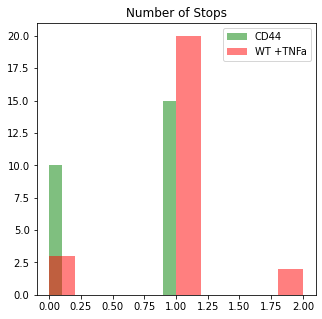

In [455]:
compare_stops(cd44_stops,"CD44",wt_stops,"WT +TNFa")

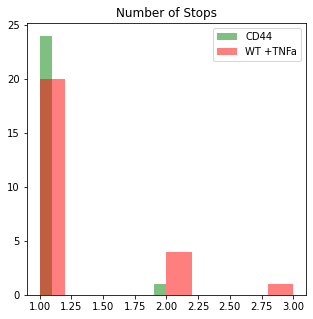

In [462]:
compare_stops(inter_cd44_stops,"CD44",inter_wt_stops,"WT +TNFa")

# Visualize Velocity vs Distance

## TODO:
1. Trying out polynomial fits
2. Make a unified visualization method
3. Pull visualization methods into script, save notebook for analyses
4. **This viz ain't it, pick a diff method**

In [ ]:
def plot_n_trend(data,ax,point_color,line_color):
    for i,track in data.groupby(by="TID"):
        x = track["d_off"]
        y = track["v"]
        ax.plot(x,y,"o",color=point_color,alpha=0.3)
        
        trend = np.polyfit(x,y,2)
        trendpoly = np.poly1d(trend)
        ax.plot(x, trendpoly(x),color=line_color,alpha=0.5)
        
def plot_pops(pops,title):
    sep_colors = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', 
                  '#f58231', '#911eb4', '#46f0f0', '#f032e6', 
                  '#bcf60c', '#fabebe', '#008080', '#e6beff', 
                  '#9a6324', '#fffac8', '#800000', '#aaffc3', 
                  '#808000', '#ffd8b1', '#000075', '#808080', 
                  '#ffffff', '#000000']   
    fig, ax = plt.subplots(figsize=(10,10))
    
    for i,pop in enumerate(pops):
        plot_n_trend(pop,ax,sep_colors[i],sep_colors[i])
    ax.set_ylim([0,60])
    ax.set_ylabel("Velocity [pixels/sec]")
    
    #ax.set_xlim([0,100])
    ax.set_xlabel("Distance from start [pixels]")

    ax.set_title(title)
    #ax.legend(loc="upper right")
    plt.show()
    
plot_pops([ln7,ln8],"CD44 vs WT +TNFa")

# Two Population Plotting

## TODO:
1. This needs to be made more general

In [310]:
def get_range(pop1,pop2,column):
    maximum = max(pop1[column].max(),pop2[column].max())
    minimum = min(pop1[column].min(),pop2[column].min())
    return [minimum,maximum]

def two_pop_plot(pop1, pop1_label, pop2, pop2_label, x,y):
    fig, ax = plt.subplots(figsize=(10,10))
    
    # PLOT lines by track
    for i,track in pop1.groupby("TID"):
        #ax.scatter(track[x], track[y], color="green", alpha = 0.5,label=pop1_label)
        ax.plot(track[x], track[y], color="green", alpha = 0.5,label=pop1_label)
    for i,track in pop2.groupby("TID"):
        #ax.scatter(track[x], track[y], color="red", alpha=0.5,label=pop2_label)
        ax.plot(track[x], track[y], color="red", alpha=0.5,label=pop2_label)
    
    ax.set_xlim(get_range(pop1,pop2,x))
    ax.set_xlabel(x)
    
    ax.set_ylim(get_range(pop1,pop2,y))
    ax.set_ylabel(y)

    ax.set_title(f"{y} vs {x} ({pop1_label} green {pop2_label} red)")
    plt.show()

# Delta V vs Offset Distance

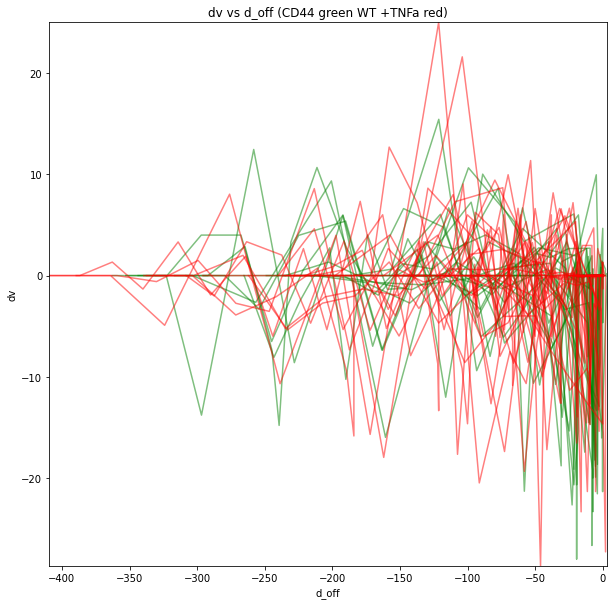

In [311]:
two_pop_plot(ln7,"CD44",ln8,"WT +TNFa","d_off","dv")

# Velocity vs Offset Distance

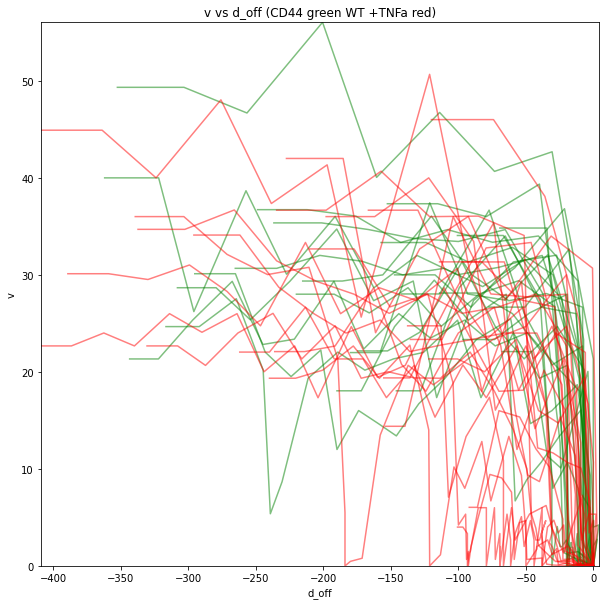

In [325]:
two_pop_plot(ln7,"CD44",ln8,"WT +TNFa","d_off","v")

# Delta V vs Corrected Time (Interpolated)

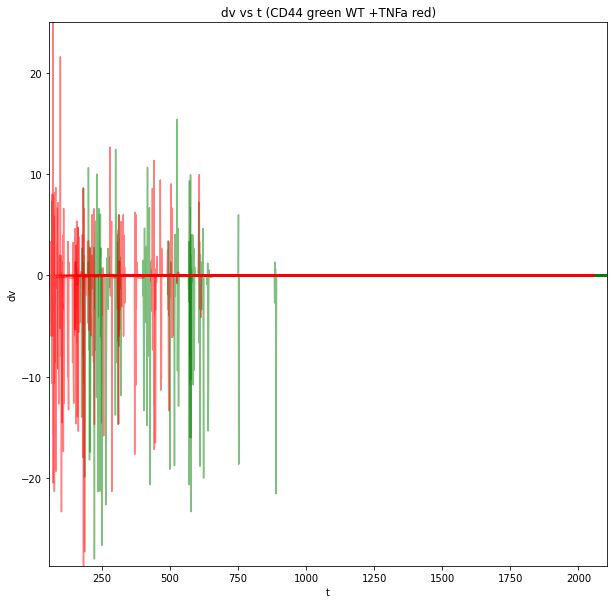

In [463]:
two_pop_plot(inter7,"CD44",inter8,"WT +TNFa","t","dv")

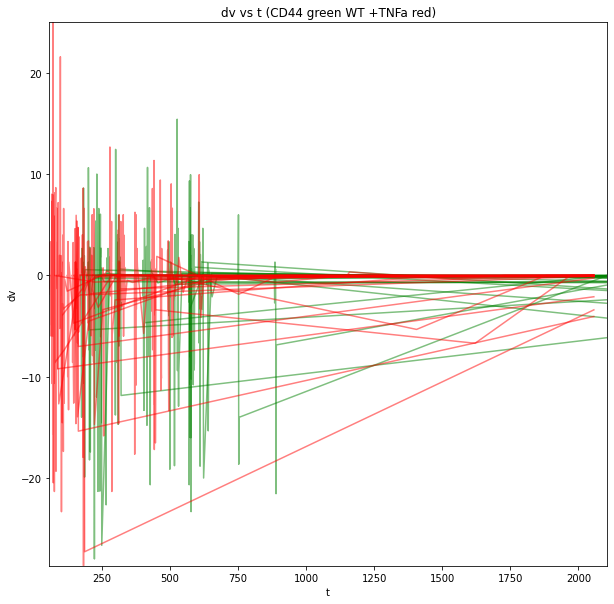

In [466]:
two_pop_plot(ln7,"CD44",ln8,"WT +TNFa","t","dv")

# Velocity vs Corrected Time (Interpolated)

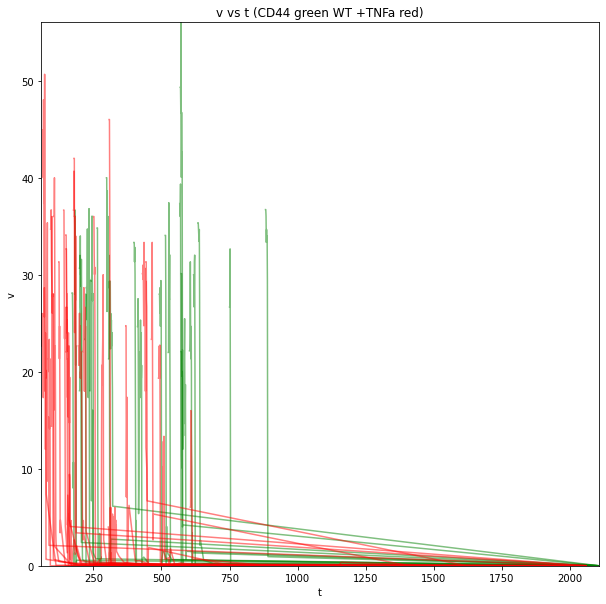

In [467]:
two_pop_plot(inter7,"CD44",inter8,"WT +TNFa","t","v")

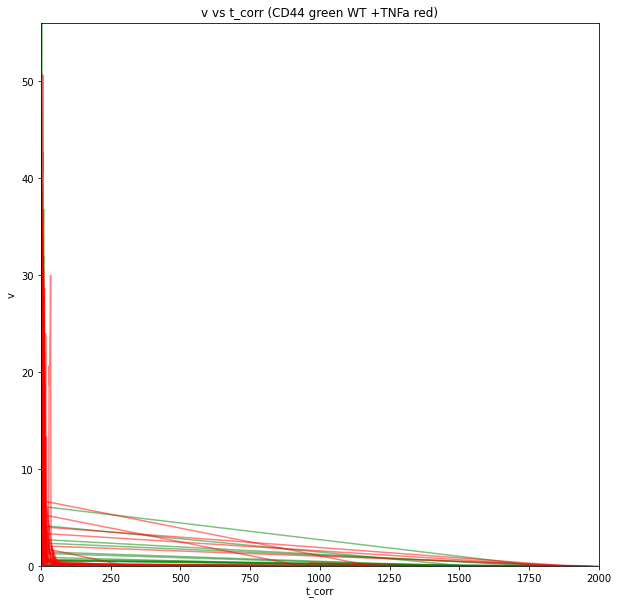

In [327]:
two_pop_plot(ln7,"CD44",ln8,"WT +TNFa","t_corr","v")

## Delta V vs Distance

In [ ]:
two_pop_plot(ln7,"CD44",ln8,"WT +TNFa","dist","dv")

## Delta V vs t

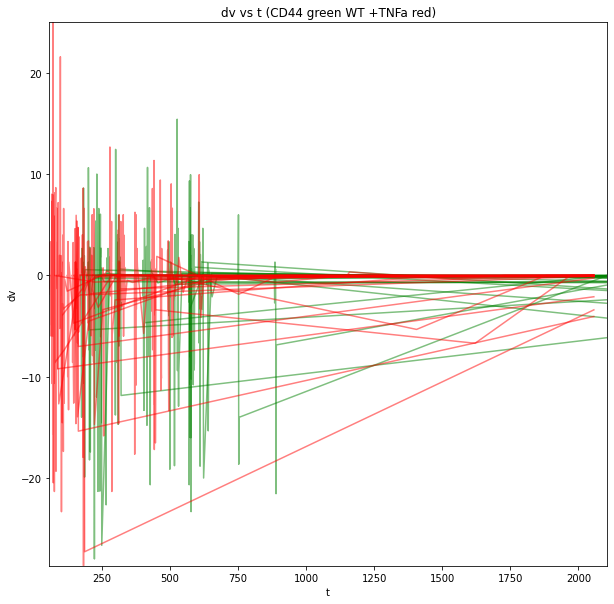

In [162]:
two_pop_plot(ln7,"CD44",ln8,"WT +TNFa","t","dv")

# Delta V vs Corrected time

In [ ]:
two_pop_plot(ln7,"CD44",ln8,"WT +TNFa","t_corr","dv")

# Velocity vs Distance

In [ ]:
two_pop_plot(ln7,"CD44",ln8,"WT +TNFa","dist","v")

# Velocity vs Time

In [ ]:
two_pop_plot(ln7,"CD44",ln8,"WT +TNFa","t","v")

# Velocity vs Corrected time

In [ ]:
two_pop_plot(ln7,"CD44",ln8,"WT +TNFa","t_corr","v")

# OLD STUFF

## TODO: Move to data driven approach, make reusable analyses
1. Separate the old experiment out into its own thing
2. Pull out old visualizations and incorporate into new experiments
3. Trash the rest

In [ ]:
data["attached"] = data["TID"]>50

# Separate attached/non-attached cells
1. I annotated these 1-50 non-attached and 51-100 attached
2. Programmatic way would utilize track having a t=2000 point

In [ ]:
attached = data[data["TID"] > 50]
zoomers = data[data["TID"] <= 50]

# Velocities

In [ ]:
data["v"].describe()

# Observations

It seems that unattached T cells have a huuuge range of velocities, but the means of both populations is close to
the same. Maybe there is a temporal component that is charecteristic. The attached population definitely expands
its range toward the lower end.

In [ ]:
fig,ax = plt.subplots(figsize= (10,10))
bplot = sns.boxplot(ax= ax, 
                    y='v', x='attached', 
                    data=data, 
                    width=0.5,
                    palette="colorblind")

There might be some issues here with the number of PID per track for attached vs non-attached that is leading to this data.
Attached cells present more points because they remain on the screen for longer leading to issues in population sizes.
Need to choose metric that compensates/takes this into account.

In [ ]:
fig,ax = plt.subplots()
attached.groupby("TID")["PID"].count().plot.hist(ax=ax,alpha=0.5,bins=10,label="attached")
zoomers.groupby("TID")["PID"].count().plot.hist(ax=ax,alpha=0.5,bins=10,label="unattached")
ax.legend(loc="upper right")
ax.set_title("Number of Points per Track")